# Required Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import time
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import math
te = TransactionEncoder()

# Function to create tree node
The below code defines a class called `treeNode`. This class represents a node in a tree data structure, which is commonly used in various applications like decision trees, hierarchical data structures, and more. Let's break down the code and explain its key components:

1. **Constructor (`__init__` method):**
   - The `__init__` method is the constructor of the `treeNode` class. It initializes the attributes of a tree node when an instance of the class is created.
   - Parameters:
     - `nameValue`: This parameter represents the name or label of the node.
     - `numOccur`: This parameter represents the count or support associated with the node.
     - `parentNode`: This parameter is a reference to the parent node in the tree (the node that this new node will be a child of).
   - Attributes:
     - `self.name`: Stores the name or label of the node.
     - `self.count`: Stores the count or support associated with the node.
     - `self.children`: This is a dictionary that will store references to the child nodes of the current node. The keys of this dictionary will be the names of the child nodes, and the values will be references to the corresponding child `treeNode` objects.

2. **Increment Method (`inc`):**
   - The `inc` method is used to increment the count (`self.count`) of the current node by a specified value (`numOccur`).
   
3. **Display Method (`disp`):**
   - The `disp` method is used to display the tree structure starting from the current node. It is a recursive function that prints the name and count of the current node and then calls itself for each child node.
   - Parameters:
     - `ind`: This parameter represents the current level of indentation for printing, which helps in visualizing the tree structure.

In [2]:
class treeNode:
    def __init__(self, nameValue, numOccur, parentNode):
        self.name = nameValue #Name of the node
        self.count = numOccur #Support
        self.children = {} #For storing children nodes
    
    def inc(self, numOccur):#For increasing count
        self.count += numOccur

    def disp(self, ind=1):# for displaying the tree
        if self.name!=None:
            print ('  '*ind, self.name, ' ', self.count)
            for child in self.children.values():
                child.disp(ind+1)

# Function to create AFOPT tree
The below code defines two functions, `createAFOPTtree` and `updateAFOPTtree`, which are related to generating a Frequent Pattern Tree (FP-Tree) for mining frequent itemsets in a dataset using the Apriori algorithm. Here's an explanation of each function:

1. **createAFOPTtree**:
   - This function takes two parameters: `dataSet`, which is the input dataset, and `minSup`, which is the minimum support threshold (defaulted to 1 if not provided).
   - `headerTable` is a dictionary used to store the support counts of individual items in the dataset.
   - It starts by scanning the `dataSet` to populate `headerTable` with the count of each item.
   - Next, it filters the items in `headerTable` to include only those that meet the minimum support threshold, creating `freqItemSet`.
   - If there are no frequent items, the function returns `None` for both the FP-Tree and the header table.
   - Otherwise, it initializes an FP-Tree with a root node and proceeds to process each transaction in the dataset.
   - For each transaction, it filters and sorts the frequent items according to their support counts and then updates the FP-Tree using the `updateAFOPTtree` function.
   - Finally, it returns the constructed FP-Tree (`retTree`) and the header table.

2. **updateAFOPTtree**:
   - This function is called by `createAFOPTtree` to update the FP-Tree with a transaction's items.
   - It takes four parameters: `items`, which is a list of items in the transaction, `inTree`, which is the current node in the FP-Tree being processed, `headerTable`, which is the header table for frequent items, and `count`, which is the count of the transaction.
   - It checks if the first item in the `items` list is already a child of the current node (`inTree`). If it is, it increments the count of that child node.
   - If the item is not a child, it creates a new child node and updates its count.
   - The function then recurses with the remaining items in the `items` list, using the newly created or existing child node as the current node.
   - This recursive process builds the FP-Tree structure.

In [3]:
def createAFOPTtree(dataSet, minSup=1):
    headerTable = {}
    support=minSup
    for trans in dataSet:
        for item in trans:
            headerTable[item] = headerTable.get(item, 0) + 1
    #Header table of frequent 1-itemsets
    headerTable = dict(filter(lambda elem: elem[1] >= support, headerTable.items()))
    freqItemSet = set(headerTable.keys()) # list of Frequent itemsets that meet the minimum support
    if len(freqItemSet) == 0:
        return None, None
    for k in headerTable:
        headerTable[k] = [headerTable[k], None] # element: [count, node]

    retTree = treeNode('Root', 1, None)
    for tranSet in dataSet:
        localD = {}
        for item in tranSet:
            if item in freqItemSet: # Filter, only take the frequent items in the sample that meet the minimum support
                localD[item] = headerTable[item][0] # element : count
        if len(localD) > 0:
            # Sort single samples according to global frequency from small to large
            orderedItem = [v[0] for v in sorted(localD.items(), key=lambda p:p[1], reverse=False)]
            #orderedItem = [v[0] for v in sorted(localD.items(), key=lambda p:(p[1], -ord(p[0])), reverse=False)]
            # Update the tree with filtered and sorted samples
            updateAFOPTtree(orderedItem, retTree, headerTable, 1)
    return retTree, headerTable

def updateAFOPTtree(items, inTree, headerTable, count):
    if items[0] in inTree.children:
        # Determine whether the first node of items has been used as a child node
        inTree.children[items[0]].inc(count)
    else:
        # Create new branch
        inTree.children[items[0]] = treeNode(items[0], count, inTree)
    # Recursive
    if len(items) > 1:
        updateAFOPTtree(items[1::], inTree.children[items[0]], headerTable, count)

# Function for getting all path from a node
The provided function `ascendAFOPTtree` is used to traverse an FP-Tree (Frequent Pattern Tree). This function traverses the tree from a given node to its ancestors and collects the paths from the node to the root of the tree. Each path is represented as a dictionary where keys are item names, and values are their corresponding counts.

Here's an explanation of the function:

- **Parameters**:
  - `node`: This parameter is the current node from which the traversal will start.
  - `path`: This parameter is a list that keeps track of the items encountered along the path from the root to the current node. It is used for accumulating the items in the path.

- **Functionality**:
  - The function initializes an empty list `paths` to store the paths from the current node to the root.
  - If the `path` parameter is not provided (i.e., it's `None`), it initializes an empty list `path` to start tracking the path from the current node.
  - The function appends the name of the current node (the item it represents) to the `path` list.
  - It checks if the current node has children (child nodes). If it does, it recursively calls `ascendAFOPTtree` for each child node and extends the `paths` list with the paths obtained from the children.
  - If the current node does not have children (i.e., it's a leaf node), it creates a dictionary `dicts` where the keys are item names encountered in the `path`, and the values are the count associated with the current node. This represents a single path from the current node to the root.
  - The `dicts` dictionary is then appended to the `paths` list.
  - Finally, the function returns the list of paths collected during the traversal.

In [4]:
def ascendAFOPTtree(node, path=None):
    paths = []
    if path is None:
        path = []
    path.append(node.name)
    if node.children:
        for child in node.children.values():
            paths.extend(ascendAFOPTtree(child, path[:]))
    else:
        dicts={}
        for item in path:
            dicts[item]=node.count
        paths.append(dicts)
    return paths

# Function for push right operation
The below function `pushRight` is a recursive function used for updating an FP-Tree (Frequent Pattern Tree) structure. Its purpose is to add a branch to the right side of the tree, extending an existing path with new items.

Here's an explanation of how the function works:

- **Parameters**:
  - `items`: This parameter is a list of items that need to be added to the tree.
  - `inTree`: This parameter is the current node in the FP-Tree to which the items are being added.
  - `count`: This parameter is a list of counts associated with each item in the `items` list. Each count corresponds to the support or frequency of the respective item in a transaction.

- **Functionality**:
  - The function first checks if the first item in the `items` list is already a child of the current node (`inTree`). If it is, it increments the count associated with that child node by the corresponding count from the `count` list. This is done using the `inc` method of the `treeNode` class, which was explained in a previous response.
  - If the item is not a child of the current node, the function creates a new branch by adding a child node to `inTree`. The name of the new node is the first item in the `items` list, and its count is set to the corresponding count from the `count` list. This new child node is added to the tree structure.
  - The function then checks if there are more items left in the `items` list (i.e., the length of `items` is greater than 1). If there are more items, it recursively calls `pushRight` to continue adding the remaining items to the tree. It also passes the corresponding counts for these items in the `count` list.


In [5]:
def pushRight(items, inTree, count):
    if items[0] in inTree.children:
        # Determine whether the first node of items has been used as a child node and increase count
        inTree.children[items[0]].inc(count[0])
    else:
        # Create new branch
        inTree.children[items[0]] = treeNode(items[0], count[0], inTree)
    # Recursive
    if len(items) > 1:
        pushRight(items[1::], inTree.children[items[0]], count[1:])

# Mining Tree
The below code includes two functions, `mineTreeDense` and `mineTree`, which are used for mining frequent itemsets from an FP-Tree. These functions implements different mining strategies. Let's explain each function:

1. **mineTreeDense**:
   - This function takes three parameters: `myFPtree` (the FP-Tree), `frequentItem` (a dictionary to store frequent itemsets), and `supp` (the minimum support threshold).
   - The function starts by extracting information from the FP-Tree structure to identify frequent itemsets. It gathers information about the children of the root node, paths within the first child node, and items whose counts match the count of the parent node.
   - It then filters and processes the paths and their combinations to identify frequent itemsets based on the given support threshold.
   - After extracting frequent itemsets, it removes the first child node (as it has been processed) and pushes any remaining items to the right in the tree structure.
   - It rearranges the tree nodes based on the order of the child nodes, ensuring that the new branch is inserted in the correct position.
   - The function then recursively calls itself to mine the next branch if it exists.
   - The process continues until there are no more child nodes in the FP-Tree.
   - Finally, the function returns the `frequentItem` dictionary, which accumulates frequent itemsets.

2. **mineTree**:
   - This function is similar to `mineTreeDense` but appears to implement a different strategy for mining frequent itemsets.
   - It also takes two parameters: `myFPtree` and `frequentItem`.
   - The main difference between this function and `mineTreeDense` is the way it selects frequent itemsets. It focuses on itemsets where all items in the itemset have the same count as the first item in the itemset.
   - It processes paths and their combinations to identify these itemsets and updates the `frequentItem` dictionary accordingly.
   - Similar to `mineTreeDense`, it removes the first child node and recursively calls itself until there are no more child nodes.
   - The function then returns the `frequentItem` dictionary.

These functions are used for different strategies of mining frequent itemsets from an FP-Tree, and the choice between them may depend on specific requirements or the characteristics of the dataset. The code provided demonstrates variations in how frequent itemsets can be extracted from the FP-Tree structure.

In [6]:
def mineTreeDense(myFPtree,frequentItem,supp):
    #myFPtree.disp() #Call this to view tree before each push right
    support=supp
    #Creating list to store order of dictionary key and values
    key1=[]
    value1=[]
    for k in myFPtree.children.keys():
        key1.append(k)
        value1.append(myFPtree.children[k])
    test_dict=myFPtree.children
    res = list(test_dict.keys())[0]
    #First child node of root
    node=myFPtree.children[res] 
    #All paths of the first child node. 
    paths= ascendAFOPTtree(node) 
    dicts={} #To store items whose count is equal to parent node
    for items in paths:
        for k in items.keys():
            if k not in dicts.keys():
                dicts[k]=items[k]
            else:
                dicts[k]+=items[k]
    key=list(dicts.keys())[0]
    #Filtered dictionary for removing unwanted items
    dicts=dict(filter(lambda elem: (elem[1] == dicts[key] or elem[1]>=support), dicts.items())) 
    #Generating Itemsets
    for row in paths:
        row=dict(filter(lambda elem: elem[0] in dicts.keys(), row.items()))
        for L in range(1, len(list(row.keys()))+1):
                for subset in itertools.combinations(list(row.keys()), L):
                    if list(row.keys())[0] in list(subset):
                        if subset not in list(frequentItem.keys()):
                            frequentItem[subset]=row[list(row.keys())[0]]
                        else:
                            frequentItem[subset]+=row[list(row.keys())[0]]
    #Deleting mined node
    myFPtree.children.pop(res)
    #Push Right
    items=[]
    counts=[]
    for row in paths:
        items.append(list(row.keys())[1:])
        counts.append(list(row.values())[1:])
    if len(items[0])!=0:
        for i in range(len(items)):
            pushRight(items[i], myFPtree, counts[i])
    
    #Sorting the dictionary to insert new branch
    key2=[]
    value2=[]
    for k in myFPtree.children.keys():
        key2.append(k)
        value2.append(myFPtree.children[k])

    if len(key2)>=len(key1):
        if len(key2)-len(key1)==0:
            temp=key2[-1]
            tempval=value2[-1]
            key2=key2[:-1]
            key2.insert(1,temp)
            value2.insert(1,tempval)
        else:
            for i in range(0,(len(key2)-len(key1))+1):
                temp=key2[-1]
                tempval=value2[-1]
                key2=key2[:-1]
                value2=value2[:-1]
                key2.insert(1,temp)
                value2.insert(1,tempval)
    temp={}
    for i in range(0,len(key2)):
        temp[key2[i]]=value2[i]
    myFPtree.children=temp
    #Recursive call till no child is left
    if myFPtree.children:
        mineTreeDense(myFPtree,frequentItem,support)
    else:
        return frequentItem
    
def mineTree(myFPtree,frequentItem):
    #myFPtree.disp()
    key1=[]
    value1=[]
    for k in myFPtree.children.keys():
        key1.append(k)
        value1.append(myFPtree.children[k])
    test_dict=myFPtree.children
    res = list(test_dict.keys())[0]
    node=myFPtree.children[res]
    paths= ascendAFOPTtree(node)
    dicts={}
    for items in paths:
        for k in items.keys():
            if k not in dicts.keys():
                dicts[k]=items[k]
            else:
                dicts[k]+=items[k]
    key=list(dicts.keys())[0]
    dicts=dict(filter(lambda elem: elem[1] == dicts[key], dicts.items()))
    for row in paths:
        for L in range(1, len(list(row.keys()))+1):
                for subset in itertools.combinations(list(row.keys()), L):
                        if subset not in list(frequentItem.keys()):
                            frequentItem[subset]=row[list(row.keys())[0]]
                        else:
                            frequentItem[subset]+=row[list(row.keys())[0]]
    myFPtree.children.pop(res)
    if myFPtree.children:
        mineTree(myFPtree,frequentItem)
    else:
        return frequentItem

# Create Tree, Mine and Generate Rules
This code defines a Python function called `generaterules` that is designed to generate association rules. Here's a step-by-step explanation of what this code does:

1. `support=int(np.round(data.shape[0]*supp))`: This line calculates the minimum support count based on the input parameter `supp` (support threshold) and the number of transactions in the dataset `data`. The `np.round` function rounds the result to the nearest integer.

2. `transactions=data.shape[0]`: It calculates the total number of transactions in the dataset `data`.

3. `myFPtree, myHeaderTab = createAFOPTtree(data, support)`: A function called `createAFOPTtree` to create a frequent pattern tree (FP-tree) from the input dataset `data` with the minimum support count specified earlier.

4. `frequentItemList={}`: Initializes an empty dictionary to store frequent itemsets.

5. `mineTree(myFPtree, frequentItemList)`: A function called `mineTree` to mine frequent itemsets from the FP-tree and stores them in the `frequentItemList` dictionary.

6. `frequentItemList=dict(filter(lambda elem: elem[1] >= support, frequentItemList.items()))`: Filters the frequent itemsets to keep only those with support counts greater than or equal to the minimum support count. It discards infrequent itemsets.

7. `items=[]` and `supp=[]`: Initialize two empty lists to store itemsets and their corresponding support values.

8. `for k in frequentItemList.keys():`: Iterates through the frequent itemsets in the `frequentItemList` dictionary.

   a. `items.append(k)`: Appends the itemset `k` to the `items` list.

   b. `supp.append(round(float(frequentItemList[k])/transactions,6))`: Calculates the support of the itemset `k` as a fraction of the total transactions and appends it to the `supp` list, rounding the result to 6 decimal places.

9. `df = pd.DataFrame(list(zip(supp, items)), columns=['support', 'itemsets'])`: Creates a pandas DataFrame from the `items` and `supp` lists, with two columns: "support" and "itemsets." This DataFrame represents the frequent itemsets and their corresponding support values.

10. `rules = association_rules(df, metric="confidence", min_threshold=0)`: Generates association rules from the frequent itemsets using the pandas method `association_rules`. It calculates the rules' confidence and keeps only those with a confidence greater than or equal to 0.

11. Finally, the function returns two values: the DataFrame `df` containing frequent itemsets and their support values and the DataFrame `rules` containing association rules.

In [7]:
def generaterules(supp,data):
    support=int(np.round(data.shape[0]*supp))
    transactions=data.shape[0]
    #print(support,transactions)
    #Creating tree
    myFPtree, myHeaderTab = createAFOPTtree(data, support)
    #Mining Tree
    frequentItemList={}
    mineTree(myFPtree,frequentItemList)
    frequentItemList=dict(filter(lambda elem: elem[1] >= support, frequentItemList.items()))
    #Itemset dictionary to Dataframe
    items=[]
    supp=[]
    for k in frequentItemList.keys():
        items.append(k)
        supp.append(round(float(frequentItemList[k])/transactions,6))
    df = pd.DataFrame(list(zip(supp,items)),columns =[ 'support','itemsets'])
    df
    #Generating Rules from Itemset
    rules = association_rules(df, metric="confidence", min_threshold=0)
    return df,rules

# Adding additional measures
The below code defines a Python function called `measures` that takes a DataFrame of association rules as input and calculates several additional measures for each rule. Here's a breakdown of what this code does:

1. Initialize five empty lists: `allconf`, `maxconf`, `coherence`, `cosine`, and `kulc`. These lists will store the calculated values for different measures for each association rule.

2. Loop through the rows (rules) of the input DataFrame `rules` using the `for ind in rules.index:` loop.

3. For each rule, calculate the following measures:
   - `allconf`: This measure calculates the "all confidence" of the rule, which is the support of the rule divided by the maximum of the antecedent and consequent supports. This measure assesses how confidently the rule is supported by the data.
   - `maxconf`: This measure calculates the "maximum confidence" of the rule, which is the maximum of the confidence when considering the antecedent and the confidence when considering the consequent. It evaluates which side of the rule is more confidently supported.
   - `coherence`: This measure assesses the coherence of the rule. It calculates the support of the rule divided by the sum of the antecedent and consequent supports minus the support of the rule. It measures how well the rule "fits" within the dataset.
   - `cosine`: This measure computes the cosine similarity between the rule's antecedent and consequent based on their supports. It provides a measure of how similar the antecedent and consequent are in terms of support.
   - `kulc`: This measure calculates the Kulczynski measure, which is an average of the confidence of the rule when considering the antecedent and the confidence when considering the consequent. It provides an average measure of confidence.

4. Round each calculated measure to 6 decimal places using `round()`.

5. Add the calculated measures as new columns to the input DataFrame `rules` with the column names 'AllConf', 'MaxConf', 'Coherence', 'Cosine', and 'Kulc'.

6. Finally, return the modified `rules` DataFrame, which now contains the original association rules along with the newly calculated measures.

In [8]:
def measures(rules):
    allconf=[]
    maxconf=[]
    coherence=[]
    cosine=[]
    kulc=[]
    for ind in rules.index:
        maxsupp=max(rules['antecedent support'][ind],rules['consequent support'][ind])
        valuesallconf=rules['support'][ind]/maxsupp
        allconf.append(round(valuesallconf,6))
        maxconfvalue=max(rules['support'][ind]/rules['antecedent support'][ind],rules['support'][ind]/rules['consequent support'][ind])
        maxconf.append(round(maxconfvalue,6))
        coherence.append(rules['support'][ind]/(rules['antecedent support'][ind]+rules['consequent support'][ind]-rules['support'][ind]))
        cosine.append(rules['support'][ind]/math.sqrt(rules['antecedent support'][ind]*rules['consequent support'][ind]))
        kulc.append(0.5*((rules['support'][ind]/rules['antecedent support'][ind])+(rules['support'][ind]/rules['consequent support'][ind])))
    rules['AllConf']=allconf
    rules['MaxConf']=maxconf
    rules['Coherence']=coherence
    rules['Cosine']=cosine
    rules['Kulc']=kulc
    return rules

# Skin Dataset

In [9]:
#Reading text file
a_file = open("Skin.txt", "r")
data = []
for line in a_file:
    stripped_line= line.strip()
    line_list = stripped_line.split()
    data.append(list(line_list))
a_file.close()
data=np.array(data)
data.shape

<ipython-input-9-14fca9d2b3e5>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data=np.array(data)


(245057,)

### Generating rules for different support

In [10]:
association=[]#For storing dataframe of rules for different support
noofitems=[]#For storing number of itemset for different support
noofrules=[]#For storing number of rules for different support
for i in [0.001,0.002,0.003,0.004,0.005]:
    itemset,associationrule=generaterules(i,data)
    associationrule=measures(associationrule)
    association.append(associationrule)
    noofitems.append(itemset.shape[0])
    noofrules.append(associationrule.shape[0])      

In [11]:
noofitems

[183, 163, 153, 140, 134]

### Plot of itemsets vs number of rules

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


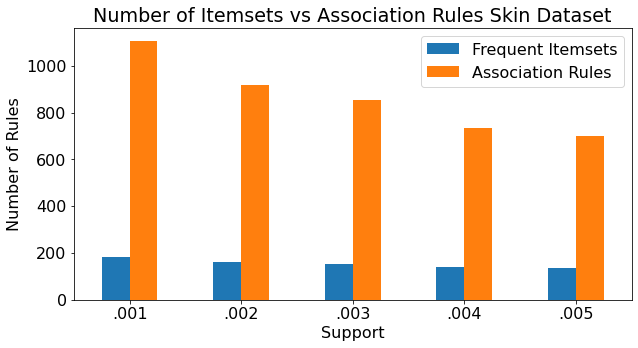

In [12]:
X = ['.001','.002','.003','.004','.005']
index = X
df = pd.DataFrame({'Frequent Itemsets': noofitems,
                   'Association Rules': noofrules}, index=index)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
ax = df.plot.bar(rot=0,figsize=(10, 5))
plt.xlabel("Support")
plt.ylabel("Number of Rules")
plt.title("Number of Itemsets vs Association Rules Skin Dataset")
plt.savefig("FreqItemmsvsRules-Skin.png")

### Finding number of confident and misleading rules

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


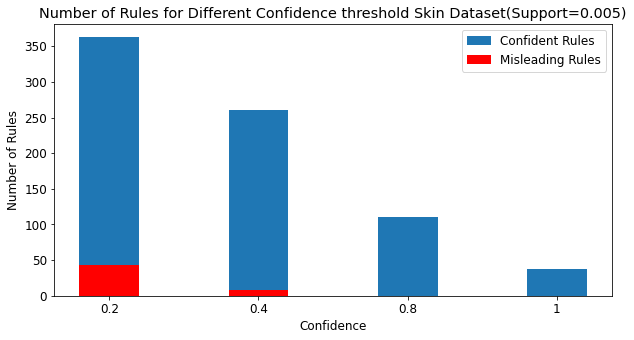

In [13]:
rules=association[4]#Dataframe for support=0.005
tempconf=[]
misrules=[]
for conf in [.2,.4,.8,1]:
        x = rules[rules['confidence']>=conf]
        tempconf.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['confidence']<rules['consequent support'])]
        misrules.append(x.shape[0])
X = ['0.2','0.4','0.8','1']
X_axis = np.arange(len(X))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.figure(figsize=(10,5))
plt.bar(X_axis, tempconf, 0.4,label='Confident Rules')
plt.bar(X_axis, misrules, 0.4,color='r',label='Misleading Rules')
plt.xticks(X_axis, X)
plt.xlabel("Confidence")
plt.ylabel("Number of Rules")
plt.title("Number of Rules for Different Confidence threshold Skin Dataset"+"("+"Support=0.005"+")")
plt.legend()
plt.savefig("Skin-Misleading.png")
plt.show()

### Top 20 misleading rules by Confidence 

In [14]:
#Misleading rules for support=0.005 and conf=0.2
rules=association[4]#Dataframe for support=0.005
x = rules[(rules['confidence']>=0.2) & (rules['confidence']<rules['consequent support'])].iloc[:, :-8].nlargest(20,'confidence',keep='all')
x

,antecedents,consequents,antecedent support,consequent support,support,confidence
402,"(5, 2)",(11),0.316335,0.792461,0.229147,0.724381
364,"(9, 3)",(11),0.046091,0.792461,0.031221,0.677377
319,(5),(11),0.411782,0.792461,0.274781,0.667297
353,(2),(11),0.390199,0.792461,0.255651,0.655181
374,"(6, 9, 3)",(11),0.041292,0.792461,0.026422,0.639882
444,"(9, 1)",(11),0.039774,0.792461,0.022448,0.564389
556,"(4, 8)",(11),0.016306,0.792461,0.007998,0.490494
241,(2),(8),0.390199,0.493808,0.184990,0.474091
407,"(11, 9, 2)",(5),0.015564,0.411782,0.005962,0.383063
368,"(6, 9)",(11),0.100205,0.792461,0.037975,0.378973


### Number of Lift Rules for different confidence threshold

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


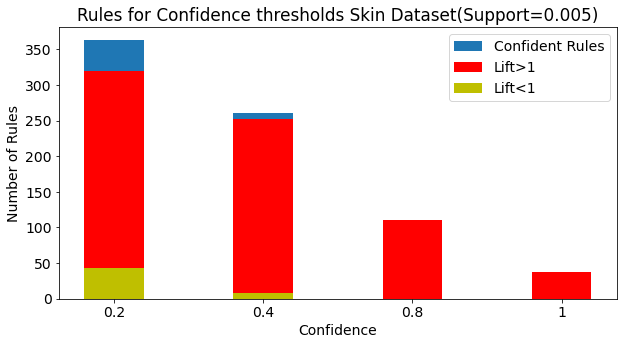

In [15]:
rules=association[4]#Dataframe for support=0.005
tempconf=[]
liftrules=[]
liftrulesneg=[]
for conf in [.2,.4,.8,1]:
        x = rules[rules['confidence']>=conf]
        tempconf.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['lift']>1)]
        liftrules.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['lift']<1)]
        liftrulesneg.append(x.shape[0])
X = ['0.2','0.4','0.8','1']
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
X_axis = np.arange(len(X))
plt.figure(figsize=(10,5))
plt.bar(X_axis, tempconf, 0.4,label='Confident Rules')
plt.bar(X_axis, liftrules, 0.4,color='r',label='Lift>1')
plt.bar(X_axis, liftrulesneg, 0.4,color='y',label='Lift<1')
plt.xticks(X_axis, X)
plt.xlabel("Confidence")
plt.ylabel("Number of Rules")
plt.title("Rules for Confidence thresholds Skin Dataset"+"("+"Support=0.005"+")")
plt.legend()
plt.savefig("ConfMis.png")
plt.show()

### Top 20 misleading rules and their lift values

In [16]:
#Misleading rules for support=0.005 and conf=0.2
rules=association[4]
x = rules[(rules['confidence']>=0.2) & (rules['confidence']<rules['consequent support'])].iloc[:, :-7].nlargest(20,'confidence',keep='all')
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
402,"(5, 2)",(11),0.316335,0.792461,0.229147,0.724381,0.914090
364,"(9, 3)",(11),0.046091,0.792461,0.031221,0.677377,0.854777
319,(5),(11),0.411782,0.792461,0.274781,0.667297,0.842057
353,(2),(11),0.390199,0.792461,0.255651,0.655181,0.826768
374,"(6, 9, 3)",(11),0.041292,0.792461,0.026422,0.639882,0.807462
444,"(9, 1)",(11),0.039774,0.792461,0.022448,0.564389,0.712198
556,"(4, 8)",(11),0.016306,0.792461,0.007998,0.490494,0.618951
241,(2),(8),0.390199,0.493808,0.184990,0.474091,0.960072
407,"(11, 9, 2)",(5),0.015564,0.411782,0.005962,0.383063,0.930258
368,"(6, 9)",(11),0.100205,0.792461,0.037975,0.378973,0.478223


### Distribution of Lift

Text(0.5, 0.98, 'Distribution of Lift(Skin Dataset)')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


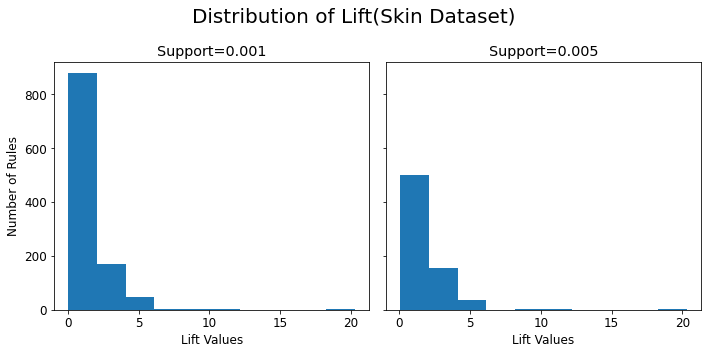

In [17]:
### Distribution of Lift
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(10,5))
axs[0].hist(association[0]['lift'])
axs[1].hist(association[4]['lift'])
axs[0].set_title('Support=0.001')
axs[1].set_title('Support=0.005')
axs[0].set_xlabel('Lift Values')
axs[0].set_ylabel('Number of Rules')
axs[1].set_xlabel('Lift Values')
plt.suptitle('Distribution of Lift(Skin Dataset)',fontsize=20)

### Distribution of Cosine

Text(0.5, 0.98, 'Distribution of Cosine')

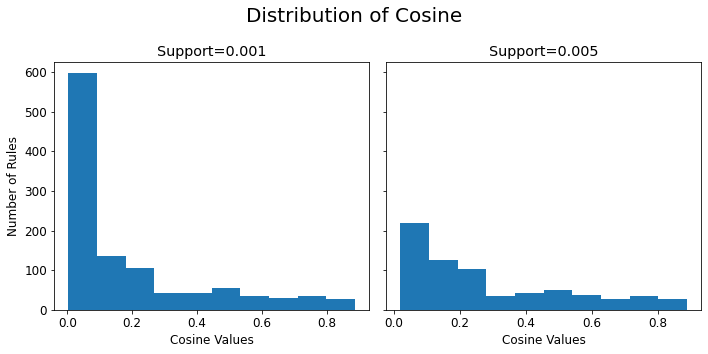

In [18]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(10,5))
axs[0].hist(association[0]['Cosine'])
axs[1].hist(association[4]['Cosine'])
axs[0].set_title('Support=0.001')
axs[1].set_title('Support=0.005')
axs[0].set_xlabel('Cosine Values')
axs[0].set_ylabel('Number of Rules')
axs[1].set_xlabel('Cosine Values')
plt.suptitle('Distribution of Cosine',fontsize=20)

### Distribution of Kulc

Text(0.5, 0.98, 'Distribution of Kulc')

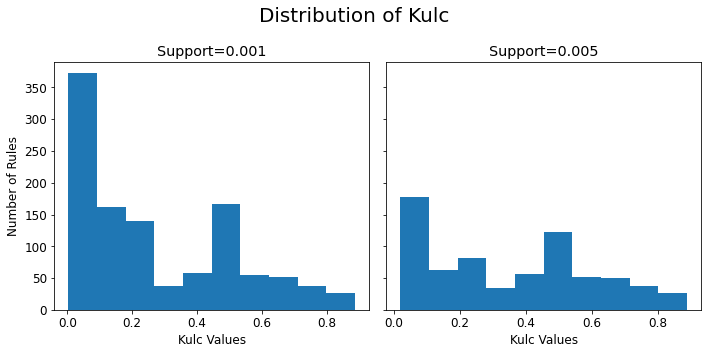

In [19]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(10,5))
axs[0].hist(association[0]['Kulc'])
axs[1].hist(association[4]['Kulc'])
axs[0].set_title('Support=0.001')
axs[1].set_title('Support=0.005')
axs[0].set_xlabel('Kulc Values')
axs[0].set_ylabel('Number of Rules')
axs[1].set_xlabel('Kulc Values')
plt.suptitle('Distribution of Kulc',fontsize=20)

### Distribution of Coherence

Text(0.5, 0.98, 'Distribution of Coherence')

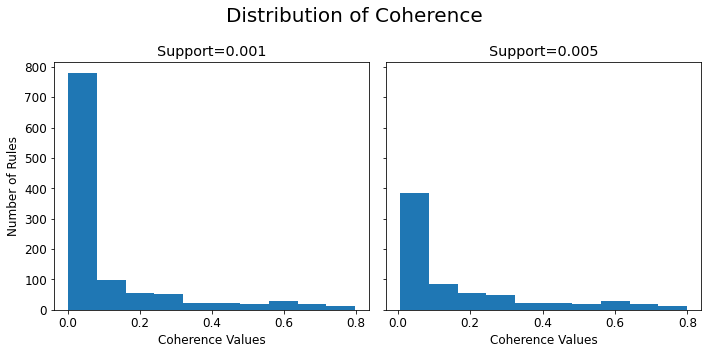

In [20]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(10,5))
axs[0].hist(association[0]['Coherence'])
axs[1].hist(association[4]['Coherence'])
axs[0].set_title('Support=0.001')
axs[1].set_title('Support=0.005')
axs[0].set_xlabel('Coherence Values')
axs[0].set_ylabel('Number of Rules')
axs[1].set_xlabel('Coherence Values')
plt.suptitle('Distribution of Coherence',fontsize=20)

In [21]:
# rules=association[0]
# fig, ax = plt.subplots()
# # plot histogram
# ax.hist(rules['lift'])
# ax.set_title('Lift(Support=0.001)')
# ax.set_xlabel('Lift Values')
# ax.set_ylabel('Frequency')

### Contradicting Lift vs Other Measures

In [22]:
### Contradicting Lift vs Other Measures
#Contradicting Rules Cosine
rules=association[4]#Dataframe for support=0.005
x = rules[(rules['lift']>1) & (rules['Cosine']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
166,"(6, 10)","(9, 3)",0.062230,0.046091,0.014870,0.238952,5.184359,0.159121,0.277653,0.280787
83,"(8, 5)","(10, 1)",0.238442,0.058121,0.032486,0.136243,2.344123,0.123017,0.275955,0.347590
78,"(10, 1)","(8, 5)",0.058121,0.238442,0.032486,0.558937,2.344123,0.123017,0.275955,0.347590
62,"(10, 8)",(5),0.046348,0.411782,0.038040,0.820747,1.993160,0.090552,0.275354,0.456563
118,"(6, 9)",(2),0.100205,0.390199,0.053849,0.537388,1.377216,0.123350,0.272326,0.337696
...,...,...,...,...,...,...,...,...,...,...
432,"(6, 2)","(11, 9)",0.059680,0.071269,0.006488,0.108713,1.525392,0.052129,0.099482,0.099874
694,"(6, 11)",(0),0.304133,0.013209,0.006117,0.020113,1.522667,0.019655,0.096510,0.241603
406,"(5, 11, 9)",(2),0.011614,0.390199,0.005962,0.513346,1.315600,0.015061,0.088564,0.264313
692,(6),(0),0.366364,0.013209,0.006117,0.016697,1.264025,0.016379,0.087932,0.239895


In [23]:
#Contradicting Rules Kulc
rules=association[4]
x = rules[(rules['lift']>1) & (rules['Kulc']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
220,"(9, 1)",(5),0.039774,0.411782,0.020999,0.527958,1.282130,0.048772,0.164084,0.289477
230,"(10, 5)","(9, 1)",0.137001,0.039774,0.017327,0.126474,3.179804,0.108669,0.234726,0.281055
166,"(6, 10)","(9, 3)",0.062230,0.046091,0.014870,0.238952,5.184359,0.159121,0.277653,0.280787
102,"(10, 9)",(6),0.161191,0.366364,0.062230,0.386064,1.053771,0.133734,0.256078,0.277961
103,(6),"(10, 9)",0.366364,0.161191,0.062230,0.169858,1.053771,0.133734,0.256078,0.277961
428,"(6, 11, 2)",(9),0.012320,0.232460,0.006488,0.526623,2.265437,0.027227,0.121236,0.277267
19,"(4, 8)",(10),0.016306,0.207539,0.008308,0.509506,2.454988,0.038546,0.142815,0.274768
156,"(6, 9)",(3),0.100205,0.317110,0.041292,0.412075,1.299471,0.109812,0.231641,0.271144
362,"(11, 9)",(3),0.071269,0.317110,0.031221,0.438073,1.381453,0.087415,0.207678,0.268264
57,"(10, 5)",(1),0.137001,0.289578,0.049813,0.363596,1.255606,0.132212,0.250091,0.267808


In [24]:
#Contradicting Rules Coherence
rules=association[4]
x = rules[(rules['lift']>1) & (rules['Coherence']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Coherence', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
296,"(6, 8)",(11),0.236357,0.792461,0.236357,1.000000,1.261892,0.298257,0.546129,0.649128
128,"(6, 10)","(9, 2)",0.062230,0.144558,0.047360,0.761048,5.264653,0.297062,0.499334,0.544334
92,(10),(2),0.207539,0.390199,0.134548,0.648302,1.661466,0.290481,0.472807,0.496561
518,"(11, 8)","(5, 2)",0.447459,0.316335,0.171552,0.383392,1.211980,0.289665,0.455980,0.462851
50,(10),(5),0.207539,0.411782,0.137001,0.660122,1.603085,0.284046,0.468641,0.496412
...,...,...,...,...,...,...,...,...,...,...
694,"(6, 11)",(0),0.304133,0.013209,0.006117,0.020113,1.522667,0.019655,0.096510,0.241603
429,"(11, 9, 2)",(6),0.015564,0.366364,0.006488,0.416859,1.137829,0.017281,0.085920,0.217284
18,"(4, 10)",(8),0.008308,0.493808,0.008308,1.000000,2.025079,0.016824,0.129709,0.508412
692,(6),(0),0.366364,0.013209,0.006117,0.016697,1.264025,0.016379,0.087932,0.239895


### Kulc vs Cosine

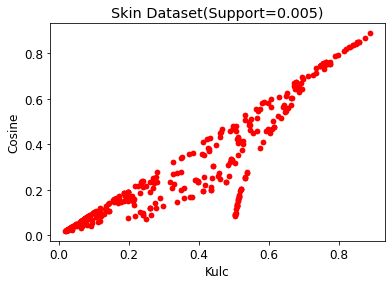

In [25]:
### Kulc vs Cosine
#CosinevsKulc
rules=association[4]
rules.plot(kind='scatter',x='Kulc',y='Cosine',color='red')
plt.title("Skin Dataset(Support=0.005)")
plt.savefig("KulcvsCosineSkin Dataset(Support=0.005).PNG")
plt.show()

### Kulc vs Coherence

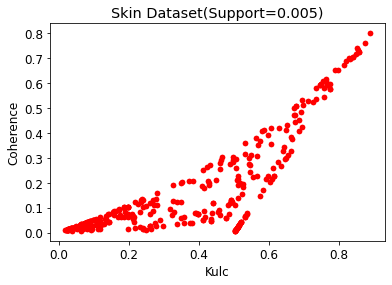

In [26]:
#CoherencevsKulc
rules=association[4]
rules.plot(kind='scatter',x='Kulc',y='Coherence',color='red')
plt.title("Skin Dataset(Support=0.005)")
plt.savefig("Skin Dataset(Support=0.005).PNG")
plt.show()

### Cosine vs Coherence

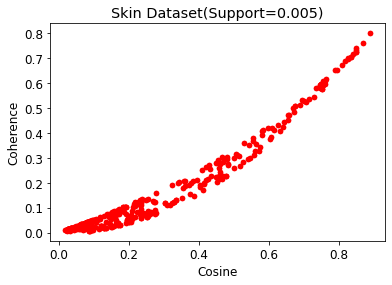

In [27]:
#CoherencevsCosine
rules=association[4]
rules.plot(kind='scatter',x='Cosine',y='Coherence',color='red')
plt.title("Skin Dataset(Support=0.005)")
plt.savefig("CosinevsKulcSkin Dataset(Support=0.005).PNG")
plt.show()

### Kulc values between .7 and .3

In [28]:
#Kulc values between .7 and .3
rules=association[4]
x = rules[(rules['Kulc']>.3) & (rules['Kulc']<.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=True)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
370,"(11, 9)",(6),0.071269,0.366364,0.037975,0.532840,1.454402,0.095019,0.235013,0.318247
70,"(1, 5)",(8),0.063585,0.493808,0.036400,0.572462,1.159281,0.069867,0.205421,0.323087
71,(8),"(1, 5)",0.493808,0.063585,0.036400,0.073713,1.159281,0.069867,0.205421,0.323087
42,"(4, 8)","(10, 1)",0.016306,0.058121,0.008308,0.509506,8.766293,0.125652,0.269871,0.326224
194,"(5, 2)",(9),0.316335,0.232460,0.087596,0.276909,1.191211,0.189931,0.323025,0.326865
...,...,...,...,...,...,...,...,...,...,...
291,"(11, 3)",(8),0.302240,0.493808,0.259213,0.857640,1.736788,0.482854,0.670968,0.691283
252,(5),"(8, 2)",0.411782,0.184990,0.177106,0.430097,2.324972,0.422017,0.641690,0.693739
249,"(8, 2)",(5),0.184990,0.411782,0.177106,0.957381,2.324972,0.422017,0.641690,0.693739
520,"(11, 2)","(8, 5)",0.255651,0.238442,0.171552,0.671040,2.814269,0.531877,0.694833,0.695255


### Lift vs Null Transactions

In [29]:
df=association[4].iloc[:, :-7]
transactions=int(data.shape[0])
list1=[]
list2=[]
list3=[]
list4=[]
for index in df.index:
    list1.append(np.round(df['support'][index]*transactions))
    list2.append(np.round((df['consequent support'][index]-df['support'][index])*transactions))
    list3.append(np.round((df['antecedent support'][index]-df['support'][index])*transactions))
    list4.append(np.round(transactions-transactions*((df['antecedent support'][index]-df['support'][index])+(df['consequent support'][index]-df['support'][index]))))
df['a and b']=list1
df['not a and b']=list2
df['a and not b']=list3
df['not a and not b']=list4  
df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,a and b,not a and b,a and not b,not a and not b
0,(4),(10),0.234733,0.207539,0.008308,0.035393,0.170539,2036.0,48823.0,55487.0,140747.0
1,(10),(4),0.207539,0.234733,0.008308,0.040031,0.170539,2036.0,55487.0,48823.0,140747.0
2,(10),(1),0.207539,0.289578,0.058121,0.280049,0.967092,14243.0,56720.0,36616.0,151721.0
3,(1),(10),0.289578,0.207539,0.058121,0.200709,0.967092,14243.0,36616.0,56720.0,151721.0
4,(10),(8),0.207539,0.493808,0.046348,0.223322,0.452244,11358.0,109653.0,39501.0,95903.0
...,...,...,...,...,...,...,...,...,...,...,...
695,"(6, 0)",(11),0.006117,0.792461,0.006117,1.000000,1.261892,1499.0,192699.0,0.0,52358.0
696,"(11, 0)",(6),0.013209,0.366364,0.006117,0.463093,1.264025,1499.0,88281.0,1738.0,155038.0
697,(6),"(11, 0)",0.366364,0.013209,0.006117,0.016697,1.264025,1499.0,1738.0,88281.0,155038.0
698,(11),"(6, 0)",0.792461,0.006117,0.006117,0.007719,1.261892,1499.0,0.0,192699.0,52358.0


### Plot of lift vs Null transactions

Text(0.5, 1.0, 'Skin Dataset(Support=0.005)')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


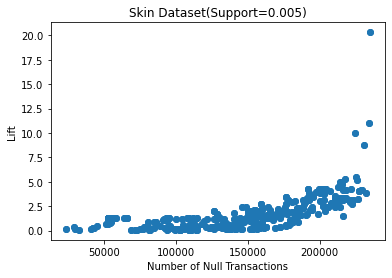

In [30]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)
plt.scatter(df["not a and not b"], df["lift"])
plt.xlabel("Number of Null Transactions")
plt.ylabel("Lift")
plt.title("Skin Dataset(Support=0.005)")

# OnlineRetail Dataset

In [31]:
a_file = open("OnlineRetail.txt", "r")
data = []
for line in a_file:
    stripped_line= line.strip()
    line_list = stripped_line.split()
    data.append(list(line_list))
a_file.close()
data=np.array(data)
data.shape

<ipython-input-31-ba789d2d374d>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data=np.array(data)


(541909,)

### Generating rules for different support

In [32]:
association1=[]#For storing dataframe of rules for different support
noofitems1=[]#For storing number of itemset for different support
noofrules1=[]#For storing number of rules for different support
for i in [0.001,0.002,0.003,0.004,0.005]:
    itemset,associationrule=generaterules(i,data)
    associationrule=measures(associationrule)
    association1.append(associationrule)
    noofitems1.append(itemset.shape[0])
    noofrules1.append(associationrule.shape[0])      

### Plot of itemsets vs number of rules

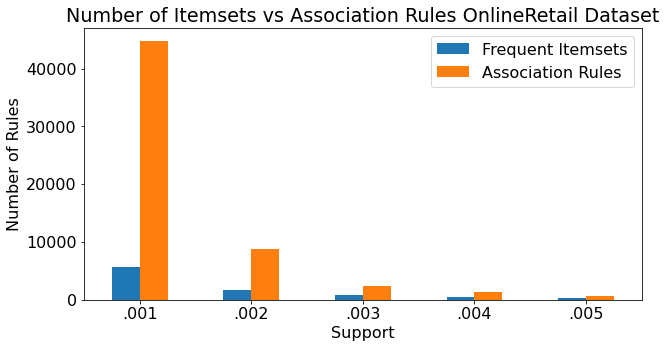

In [33]:
X = ['.001','.002','.003','.004','.005']
index = X
df = pd.DataFrame({'Frequent Itemsets': noofitems1,
                   'Association Rules': noofrules1}, index=index)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
ax = df.plot.bar(rot=0,figsize=(10, 5))
plt.xlabel("Support")
plt.ylabel("Number of Rules")
plt.title("Number of Itemsets vs Association Rules OnlineRetail Dataset")
plt.savefig("FreqItemmsvsRules-OnlineRetail.png")

### Finding number of confident and misleading rules

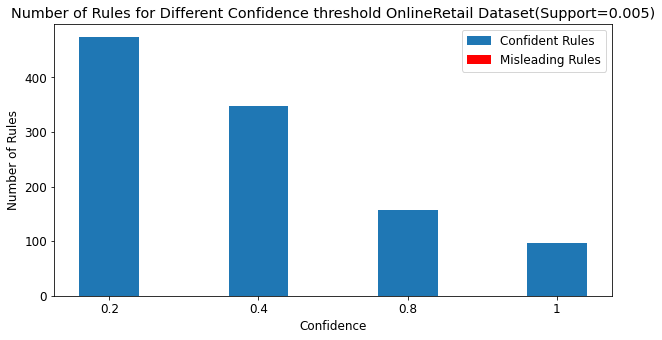

In [34]:
rules=association1[4]#Dataframe for support=0.005
tempconf=[]
misrules=[]
for conf in [.2,.4,.8,1]:
        x = rules[rules['confidence']>=conf]
        tempconf.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['confidence']<rules['consequent support'])]
        misrules.append(x.shape[0])
X = ['0.2','0.4','0.8','1']
X_axis = np.arange(len(X))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.figure(figsize=(10,5))
plt.bar(X_axis, tempconf, 0.4,label='Confident Rules')
plt.bar(X_axis, misrules, 0.4,color='r',label='Misleading Rules')
plt.xticks(X_axis, X)
plt.xlabel("Confidence")
plt.ylabel("Number of Rules")
plt.title("Number of Rules for Different Confidence threshold OnlineRetail Dataset"+"("+"Support=0.005"+")")
plt.legend()
plt.savefig("OnlineRetail-Misleading.png")
plt.show()

### Top 20 misleading rules by Confidence 

In [35]:
#Misleading rules for support=0.005 and conf=0.2
rules=association1[4]#Dataframe for support=0.005
x = rules[(rules['confidence']>=0.2) & (rules['confidence']<rules['consequent support'])].iloc[:, :-8].nlargest(20,'confidence',keep='all')
x

,antecedents,consequents,antecedent support,consequent support,support,confidence


### Number of Lift Rules for different confidence threshold

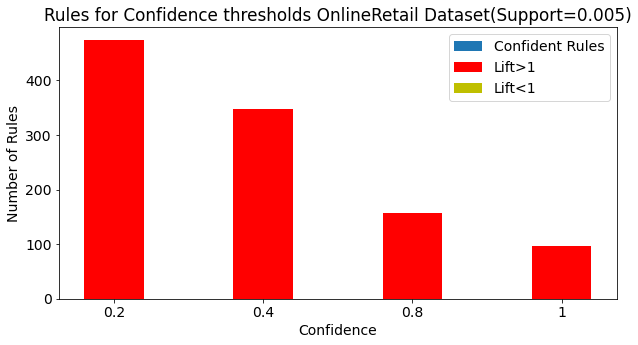

In [36]:
rules=association1[4]#Dataframe for support=0.005
tempconf=[]
liftrules=[]
liftrulesneg=[]
for conf in [.2,.4,.8,1]:
        x = rules[rules['confidence']>=conf]
        tempconf.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['lift']>1)]
        liftrules.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['lift']<1)]
        liftrulesneg.append(x.shape[0])
X = ['0.2','0.4','0.8','1']
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
X_axis = np.arange(len(X))
plt.figure(figsize=(10,5))
plt.bar(X_axis, tempconf, 0.4,label='Confident Rules')
plt.bar(X_axis, liftrules, 0.4,color='r',label='Lift>1')
plt.bar(X_axis, liftrulesneg, 0.4,color='y',label='Lift<1')
plt.xticks(X_axis, X)
plt.xlabel("Confidence")
plt.ylabel("Number of Rules")
plt.title("Rules for Confidence thresholds OnlineRetail Dataset"+"("+"Support=0.005"+")")
plt.legend()
plt.savefig("ConfMis.png")
plt.show()

### Top 20 misleading rules and their lift values

In [37]:
#Misleading rules for support=0.005 and conf=0.2
rules=association1[4]
x = rules[(rules['confidence']>=0.2) & (rules['confidence']<rules['consequent support'])].iloc[:, :-7].nlargest(20,'confidence',keep='all')
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift


### Distribution of Lift

Text(0.5, 0.98, 'Distribution of Lift(OnlineRetail Dataset)')

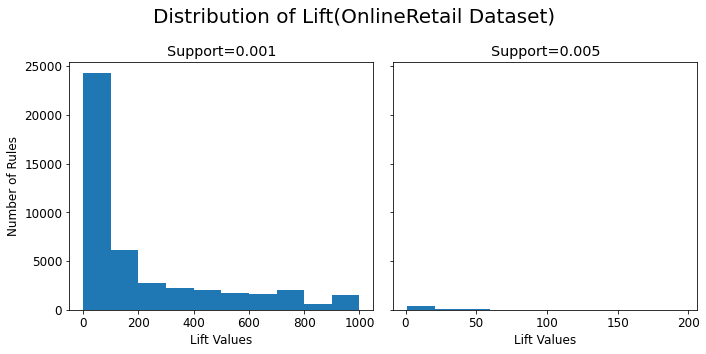

In [38]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(10,5))
axs[0].hist(association1[0]['lift'])
axs[1].hist(association1[4]['lift'])
axs[0].set_title('Support=0.001')
axs[1].set_title('Support=0.005')
axs[0].set_xlabel('Lift Values')
axs[0].set_ylabel('Number of Rules')
axs[1].set_xlabel('Lift Values')
plt.suptitle('Distribution of Lift(OnlineRetail Dataset)',fontsize=20)

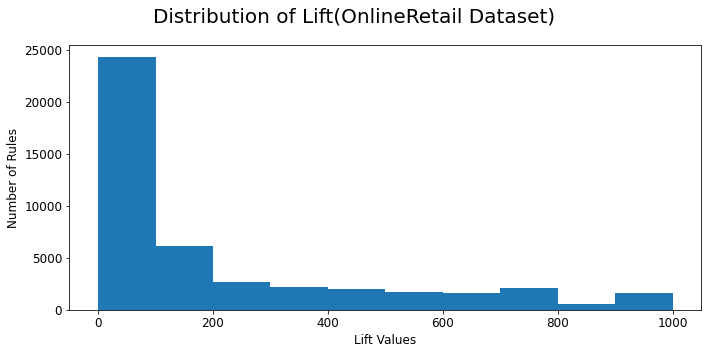

In [120]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(10,5))
axs.hist(association1[0]['lift'])
#axs[1].hist(association1[4]['lift'])
#axs.set_title('Support=0.001')
#axs[1].set_title('Support=0.005')
axs.set_xlabel('Lift Values')
axs.set_ylabel('Number of Rules')
#axs[1].set_xlabel('Lift Values')
plt.suptitle('Distribution of Lift(OnlineRetail Dataset)',fontsize=20)
plt.savefig("Distribution of Lift(OnlineRetail Dataset).png")

### Distribution of Kulc

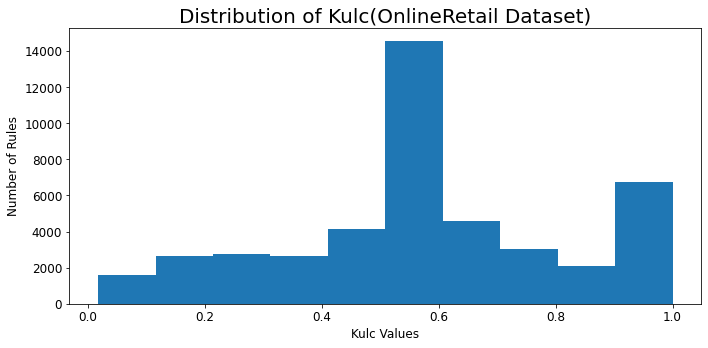

In [40]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(10,5))
axs.hist(association1[0]['Kulc'])
#axs[1].hist(association1[4]['Cosine'])
axs.set_title('Support=0.001')
#axs[1].set_title('Support=0.005')
axs.set_xlabel('Kulc Values')
axs.set_ylabel('Number of Rules')
#axs[1].set_xlabel('Cosine Values')
plt.title('Distribution of Kulc(OnlineRetail Dataset)',fontsize=20)
plt.savefig("Distribution of Kulc(OnlineRetail Dataset)")

### Distribution of Cosine

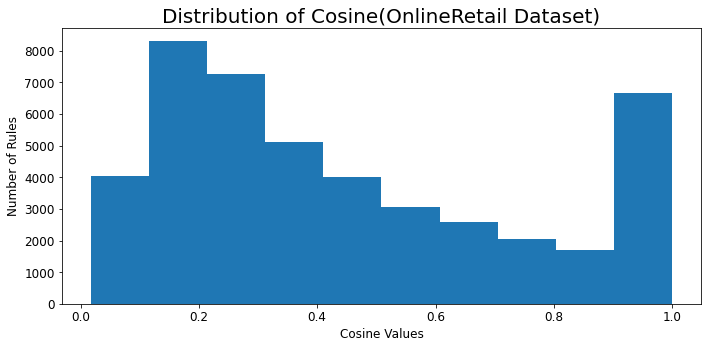

In [41]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(10,5))
axs.hist(association1[0]['Cosine'])
#axs[1].hist(association1[4]['Cosine'])
axs.set_title('Support=0.001')
#axs[1].set_title('Support=0.005')
axs.set_xlabel('Cosine Values')
axs.set_ylabel('Number of Rules')
#axs[1].set_xlabel('Cosine Values')
plt.title('Distribution of Cosine(OnlineRetail Dataset)',fontsize=20)
plt.savefig("Distribution of Cosine(OnlineRetail Dataset)")

### Distribution of Coherence

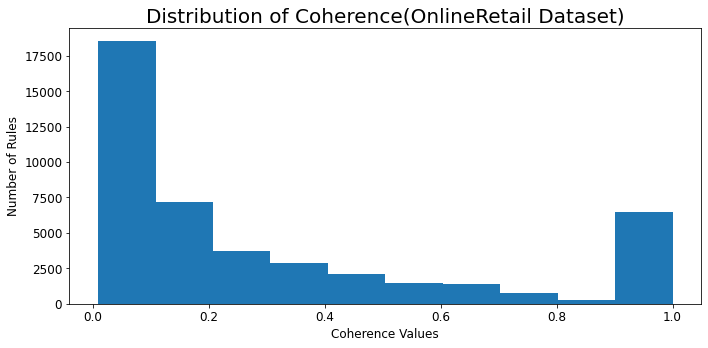

In [42]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(10,5))
axs.hist(association1[0]['Coherence'])
#axs[1].hist(association1[4]['Cosine'])
axs.set_title('Support=0.001')
#axs[1].set_title('Support=0.005')
axs.set_xlabel('Coherence Values')
axs.set_ylabel('Number of Rules')
#axs[1].set_xlabel('Cosine Values')
plt.title('Distribution of Coherence(OnlineRetail Dataset)',fontsize=20)
plt.savefig("Distribution of Coherence(OnlineRetail Dataset)")

### Contradicting Lift vs Other Measures

In [43]:
#Contradicting Rules Cosine
rules=association1[4]#Dataframe for support=0.005
x = rules[(rules['lift']>1) & (rules['Cosine']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf','antecedent support','consequent support'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='lift', ascending=False)
x.reset_index(drop=True, inplace=True)
x

,antecedents,consequents,support,confidence,lift,Coherence,Cosine,Kulc
0,(2339),(751),0.006003,0.108022,14.507390,0.105288,0.295107,0.457113
1,(1825),(90),0.005756,0.453693,13.761193,0.144261,0.281442,0.314141
2,"(2232, 1534)",(90),0.005005,0.450373,13.660512,0.128080,0.261478,0.301091
3,"(1534, 1603, 1943)",(720),0.005995,0.657130,12.766009,0.109793,0.276645,0.386797
4,(2232),(90),0.005005,0.397222,12.048355,0.123385,0.245565,0.274516
...,...,...,...,...,...,...,...,...
133,(2339),(1943),0.007516,0.135248,1.346541,0.050614,0.100601,0.105039
134,(2339),(1534),0.007014,0.126215,1.302874,0.048229,0.095595,0.099309
135,(1534),(2339),0.007014,0.072403,1.302874,0.048229,0.095595,0.099309
136,(1943),(1834),0.007025,0.069942,1.241992,0.046918,0.093408,0.097344


In [44]:
#Contradicting Rules Kulc
rules=association1[4]
x = rules[(rules['lift']>1) & (rules['Kulc']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
622,(2232),(426),0.012600,0.039346,0.005617,0.445794,11.330088,0.121242,0.252272,0.294276
98,(1534),(90),0.096874,0.032969,0.014122,0.145777,4.421638,0.122035,0.249885,0.287059
92,(2232),(90),0.012600,0.032969,0.005005,0.397222,12.048355,0.123385,0.245565,0.274516
221,(225),(2400),0.094669,0.012002,0.005743,0.060664,5.054491,0.056902,0.170376,0.269584
220,(2400),(225),0.012002,0.094669,0.005743,0.478504,5.054491,0.056902,0.170376,0.269584
...,...,...,...,...,...,...,...,...,...,...
246,(1534),(2339),0.096874,0.055572,0.007014,0.072403,1.302874,0.048229,0.095595,0.099309
247,(2339),(1534),0.055572,0.096874,0.007014,0.126215,1.302874,0.048229,0.095595,0.099309
200,(1816),(2339),0.074477,0.055572,0.006230,0.083650,1.505254,0.050315,0.096839,0.097878
433,(1834),(1943),0.056314,0.100441,0.007025,0.124747,1.241992,0.046918,0.093408,0.097344


In [45]:
#Contradicting Rules Coherence
rules=association1[4]
x = rules[(rules['lift']>1) & (rules['Coherence']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Coherence', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
390,"(1534, 1603)",(2232),0.010432,0.012600,0.005263,0.504505,40.040109,0.296190,0.459055,0.461102
631,(2353),(461),0.005084,0.017322,0.005084,1.000000,57.730054,0.293500,0.541756,0.646750
630,(461),(2353),0.017322,0.005084,0.005084,0.293500,57.730054,0.293500,0.541756,0.646750
334,(426),"(1534, 479)",0.039346,0.014423,0.012175,0.309434,21.454222,0.292710,0.511082,0.576786
331,"(1534, 479)",(426),0.014423,0.039346,0.012175,0.844138,21.454222,0.292710,0.511082,0.576786
...,...,...,...,...,...,...,...,...,...,...
432,(1943),(1834),0.100441,0.056314,0.007025,0.069942,1.241992,0.046918,0.093408,0.097344
241,(1534),(358),0.096874,0.036061,0.005691,0.058746,1.629084,0.044725,0.096287,0.108281
240,(358),(1534),0.036061,0.096874,0.005691,0.157816,1.629084,0.044725,0.096287,0.108281
77,(1943),(1605),0.100441,0.022483,0.005023,0.050009,2.224323,0.042604,0.105701,0.136711


### Kulc vs Cosine

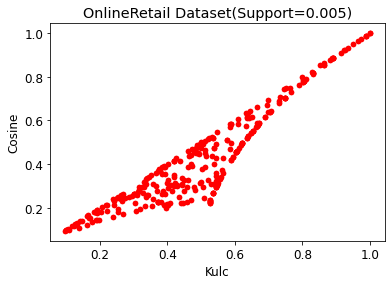

In [139]:
#CosinevsKulc
rules=association1[4]
rules.plot(kind='scatter',x='Kulc',y='Cosine',color='red')
plt.title("OnlineRetail Dataset(Support=0.005)")
plt.savefig('im14.PNG')
plt.show()

### Kulc vs Coherence

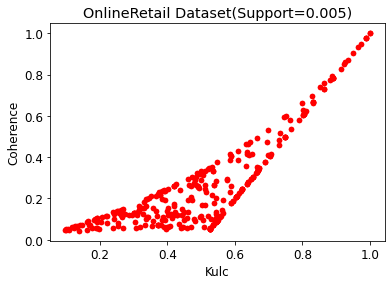

In [140]:
#CoherencevsKulc
rules=association1[4]
rules.plot(kind='scatter',x='Kulc',y='Coherence',color='red')
plt.title("OnlineRetail Dataset(Support=0.005)")
plt.savefig('im13.PNG')
plt.show()

### Coherence vs Cosine

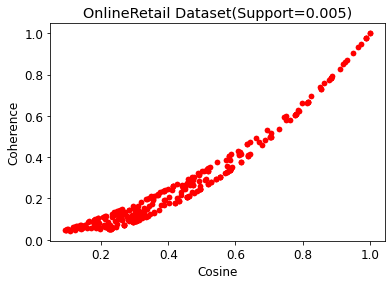

In [48]:
#CoherencevsCosine
rules=association1[4]
rules.plot(kind='scatter',x='Cosine',y='Coherence',color='red')
plt.title("OnlineRetail Dataset(Support=0.005)")
plt.show()

### Kulc between .3 & .7

In [49]:
#Kulc values between .7 and .3
rules=association1[4]
x = rules[(rules['Kulc']>.3) & (rules['Kulc']<.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=True)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
103,"(2232, 1534)",(90),0.011113,0.032969,0.005005,0.450373,13.660512,0.128080,0.261478,0.301091
4,(2183),(1097),0.023867,0.068796,0.010732,0.449659,6.536114,0.130988,0.264850,0.302828
347,(1943),"(1534, 426)",0.100441,0.018195,0.009398,0.093567,5.142477,0.086032,0.219839,0.305041
342,"(1534, 426)",(1943),0.018195,0.100441,0.009398,0.516516,5.142477,0.086032,0.219839,0.305041
214,"(1721, 1680)",(225),0.010611,0.094669,0.005842,0.550561,5.815639,0.058750,0.184323,0.306135
...,...,...,...,...,...,...,...,...,...,...
574,(1703),(1165),0.006889,0.019926,0.006889,1.000000,50.185687,0.345729,0.587987,0.672865
466,(479),"(426, 1582)",0.022170,0.008383,0.008383,0.378124,45.105999,0.378124,0.614918,0.689062
499,"(1534, 720)",(1603),0.008230,0.014464,0.007304,0.887485,61.358187,0.474594,0.669448,0.696231
284,(1156),(1317),0.007186,0.008356,0.005385,0.749374,89.680922,0.530176,0.694933,0.696910


### Lift vs Null Transactions

In [50]:
df=association1[4].iloc[:, :-7]
transactions=int(data.shape[0])
list1=[]
list2=[]
list3=[]
list4=[]
for index in df.index:
    list1.append(np.round(df['support'][index]*transactions))
    list2.append(np.round((df['consequent support'][index]-df['support'][index])*transactions))
    list3.append(np.round((df['antecedent support'][index]-df['support'][index])*transactions))
    list4.append(np.round(transactions-transactions*((df['antecedent support'][index]-df['support'][index])+(df['consequent support'][index]-df['support'][index]))))
df['a and b']=list1
df['not a and b']=list2
df['a and not b']=list3
df['not a and not b']=list4  
df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,a and b,not a and b,a and not b,not a and not b
0,(2183),(1126),0.023867,0.026351,0.018704,0.783676,29.739904,10136.0,4144.0,2798.0,534967.0
1,(1126),(2183),0.026351,0.023867,0.018704,0.709802,29.739904,10136.0,2798.0,4144.0,534967.0
2,(1084),(2183),0.030031,0.023867,0.013798,0.459459,19.250788,7477.0,5456.0,8797.0,527656.0
3,(2183),(1084),0.023867,0.030031,0.013798,0.578120,19.250788,7477.0,8797.0,5456.0,527656.0
4,(2183),(1097),0.023867,0.068796,0.010732,0.449659,6.536114,5816.0,31465.0,7118.0,503326.0
...,...,...,...,...,...,...,...,...,...,...,...
635,"(2277, 2353)",(461),0.005084,0.017322,0.005084,1.000000,57.730054,2755.0,6632.0,0.0,535277.0
636,"(461, 2353)",(2277),0.005084,0.006957,0.005084,1.000000,143.740118,2755.0,1015.0,0.0,540894.0
637,(2277),"(461, 2353)",0.006957,0.005084,0.005084,0.730775,143.740118,2755.0,0.0,1015.0,540894.0
638,(461),"(2277, 2353)",0.017322,0.005084,0.005084,0.293500,57.730054,2755.0,0.0,6632.0,535277.0


### Plot of lift vs Null transactions

Text(0.5, 1.0, 'OnlineRetail(Support=0.005)')

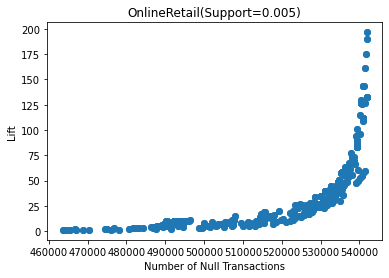

In [51]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)
plt.scatter(df["not a and not b"], df["lift"])
plt.xlabel("Number of Null Transactions")
plt.ylabel("Lift")
plt.title("OnlineRetail(Support=0.005)")

# Accidents Dataset

In [52]:
attributes=pd.read_excel('OnlineRetailZZAtrributes.xlsx',header=None)
attributes
attrdict={}
for index in attributes.index:
    attrdict[attributes[1][index]]=attributes[0][index]

In [57]:
a_file = open("Accidents.txt", "r")
data = []
for line in a_file:
    stripped_line= line.strip()
    line_list = stripped_line.split()
    data.append(list(line_list))
a_file.close()
data=np.array(data)
# te_ary = te.fit(data).transform(data)
# dfr = pd.DataFrame(te_ary, columns=te.columns_)
# datafrm=fpgrowth(dfr, min_support=0.01,use_colnames=True)
# datafrm

<ipython-input-57-c6322fae2123>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data=np.array(data)


In [54]:
associationrule = association_rules(datafrm, metric="confidence", min_threshold=0)
associationrule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(11),(8),0.792461,0.493808,0.447459,0.564645,1.143452,0.056136,1.162713
1,(8),(11),0.493808,0.792461,0.447459,0.906141,1.143452,0.056136,2.211178
2,(8),(1),0.493808,0.289578,0.049217,0.099669,0.344186,-0.093778,0.789068
3,(1),(8),0.289578,0.493808,0.049217,0.169962,0.344186,-0.093778,0.609842
4,(1),(5),0.289578,0.411782,0.063585,0.219579,0.533242,-0.055658,0.753719
...,...,...,...,...,...,...,...,...,...
543,(5),"(11, 7, 2)",0.411782,0.059676,0.051608,0.125330,2.100169,0.027035,1.075061
544,(7),"(11, 5, 2)",0.247049,0.229147,0.051608,0.208900,0.911642,-0.005002,0.974407
545,(2),"(11, 5, 7)",0.390199,0.060712,0.051608,0.132262,2.178496,0.027918,1.082455
546,(11),(0),0.792461,0.013209,0.013209,0.016669,1.261893,0.002741,1.003518


### Generating rules for different support

In [58]:
association2=[]#For storing dataframe of rules for different support
noofitems2=[]#For storing number of itemset for different support
noofrules2=[]#For storing number of rules for different support
for i in [0.7,0.8,0.9]:
    support=int(np.round(data.shape[0]*i))
    transactions=data.shape[0]
    #print(support,transactions)
    myFPtree, myHeaderTab = createAFOPTtree(data, support)
    frequentItemList={}
    mineTreeDense(myFPtree,frequentItemList,support)
    frequentItemList=dict(filter(lambda elem: elem[1] >= support, frequentItemList.items()))
    items=[]
    supp=[]
    for k in frequentItemList.keys():
        items.append(k)
        supp.append(round(float(frequentItemList[k])/transactions,6))
    df = pd.DataFrame(list(zip(supp,items)),columns =[ 'support','itemsets'])
    associationrule = association_rules(df, metric="confidence", min_threshold=0)
    associationrule=measures(associationrule)
    association2.append(associationrule)
    noofitems2.append(df.shape[0])
    noofrules2.append(associationrule.shape[0])   

In [60]:
noofrules2

[7402, 1432, 180]

### Plot of itemsets vs number of rules

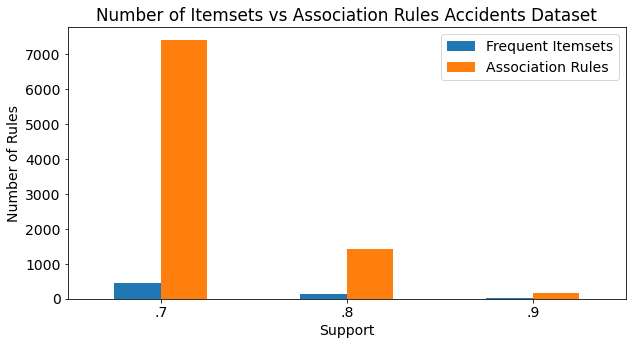

In [61]:
X = ['.7','.8','.9']
index = X
df = pd.DataFrame({'Frequent Itemsets': noofitems2,
                   'Association Rules': noofrules2}, index=index)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
ax = df.plot.bar(rot=0,figsize=(10, 5))
plt.xlabel("Support")
plt.ylabel("Number of Rules")
plt.title("Number of Itemsets vs Association Rules Accidents Dataset")
plt.savefig("FreqItemmsvsRules-Accidents.png")

### Finding number of confident and misleading rules

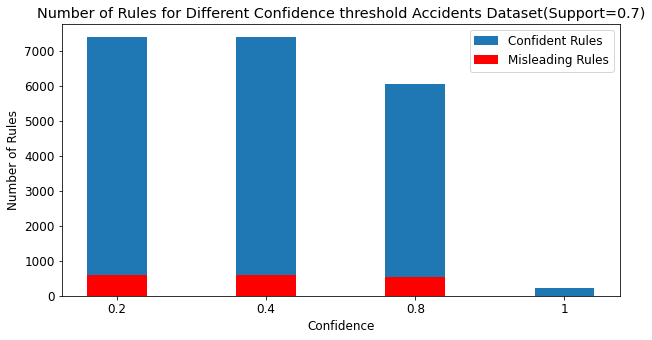

In [62]:
rules=association2[0]#Dataframe for support=0.7
tempconf=[]
misrules=[]
for conf in [.2,.4,.8,1]:
        x = rules[rules['confidence']>=conf]
        tempconf.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['confidence']<rules['consequent support'])]
        misrules.append(x.shape[0])
X = ['0.2','0.4','0.8','1']
X_axis = np.arange(len(X))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.figure(figsize=(10,5))
plt.bar(X_axis, tempconf, 0.4,label='Confident Rules')
plt.bar(X_axis, misrules, 0.4,color='r',label='Misleading Rules')
plt.xticks(X_axis, X)
plt.xlabel("Confidence")
plt.ylabel("Number of Rules")
plt.title("Number of Rules for Different Confidence threshold Accidents Dataset"+"("+"Support=0.7"+")")
plt.legend()
plt.savefig("Accidents-Misleading.png")
plt.show()

### Top 20 misleading rules by Confidence

In [63]:
### Top 20 misleading rules by Confidence
#Misleading rules for support=0.005 and conf=0.2
rules=association2[0]#Dataframe for support=0.7
x = rules[(rules['confidence']>=0.2) & (rules['confidence']<rules['consequent support'])].iloc[:, :-8].nlargest(20,'confidence',keep='all')
x

,antecedents,consequents,antecedent support,consequent support,support,confidence
1749,"(15, 21)",(12),0.714583,0.998195,0.713269,0.998161
1878,"(15, 21, 17)",(12),0.714583,0.998195,0.713269,0.998161
1881,"(15, 21)","(12, 17)",0.714583,0.998195,0.713269,0.998161
1730,"(15, 29)",(12),0.702678,0.998195,0.701343,0.998100
1835,"(15, 29, 17)",(12),0.702678,0.998195,0.701343,0.998100
1838,"(15, 29)","(12, 17)",0.702678,0.998195,0.701343,0.998100
1720,(15),(12),0.802177,0.998195,0.800651,0.998098
1815,"(15, 17)",(12),0.802177,0.998195,0.800651,0.998098
1817,(15),"(12, 17)",0.802177,0.998195,0.800651,0.998098
6076,(29),(18),0.879406,0.996708,0.876484,0.996677


### Number of Lift Rules for different confidence threshold

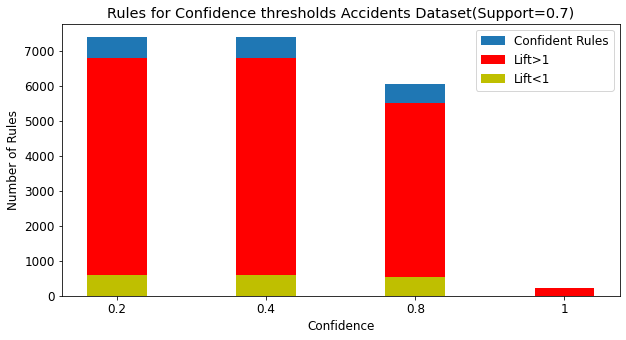

In [64]:
rules=association2[0]#Dataframe for support=0.7
tempconf=[]
liftrules=[]
liftrulesneg=[]
for conf in [.2,.4,.8,1]:
        x = rules[rules['confidence']>=conf]
        tempconf.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['lift']>1)]
        liftrules.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['lift']<1)]
        liftrulesneg.append(x.shape[0])
X = ['0.2','0.4','0.8','1']
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
X_axis = np.arange(len(X))
plt.figure(figsize=(10,5))
plt.bar(X_axis, tempconf, 0.4,label='Confident Rules')
plt.bar(X_axis, liftrules, 0.4,color='r',label='Lift>1')
plt.bar(X_axis, liftrulesneg, 0.4,color='y',label='Lift<1')
plt.xticks(X_axis, X)
plt.xlabel("Confidence")
plt.ylabel("Number of Rules")
plt.title("Rules for Confidence thresholds Accidents Dataset"+"("+"Support=0.7"+")")
plt.legend()
plt.savefig("ConfMis.png")
plt.show()

### Top 20 misleading rules and their lift values

In [65]:
#Misleading rules for support=0.7 and conf=0.2
rules=association2[0]
x = rules[(rules['confidence']>=0.2) & (rules['confidence']<rules['consequent support'])].iloc[:, :-7].nlargest(20,'confidence',keep='all')
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
1749,"(15, 21)",(12),0.714583,0.998195,0.713269,0.998161,0.999966
1878,"(15, 21, 17)",(12),0.714583,0.998195,0.713269,0.998161,0.999966
1881,"(15, 21)","(12, 17)",0.714583,0.998195,0.713269,0.998161,0.999966
1730,"(15, 29)",(12),0.702678,0.998195,0.701343,0.998100,0.999905
1835,"(15, 29, 17)",(12),0.702678,0.998195,0.701343,0.998100,0.999905
1838,"(15, 29)","(12, 17)",0.702678,0.998195,0.701343,0.998100,0.999905
1720,(15),(12),0.802177,0.998195,0.800651,0.998098,0.999903
1815,"(15, 17)",(12),0.802177,0.998195,0.800651,0.998098,0.999903
1817,(15),"(12, 17)",0.802177,0.998195,0.800651,0.998098,0.999903
6076,(29),(18),0.879406,0.996708,0.876484,0.996677,0.999969


### Distribution of Lift

Text(0.5, 0.98, 'Distribution of Lift(Accidents Dataset)')

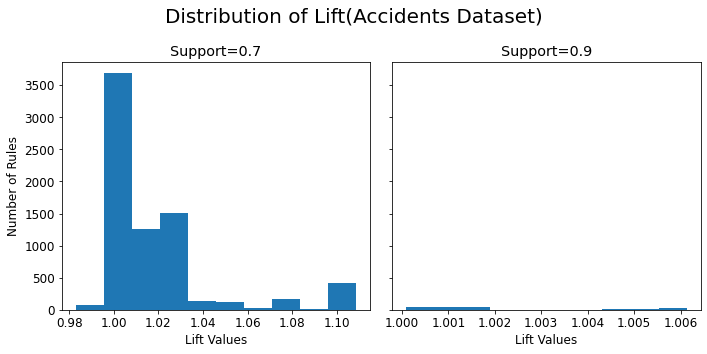

In [66]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(10,5))
axs[0].hist(association2[0]['lift'])
axs[1].hist(association2[2]['lift'])
axs[0].set_title('Support=0.7')
axs[1].set_title('Support=0.9')
axs[0].set_xlabel('Lift Values')
axs[0].set_ylabel('Number of Rules')
axs[1].set_xlabel('Lift Values')
plt.suptitle('Distribution of Lift(Accidents Dataset)',fontsize=20)

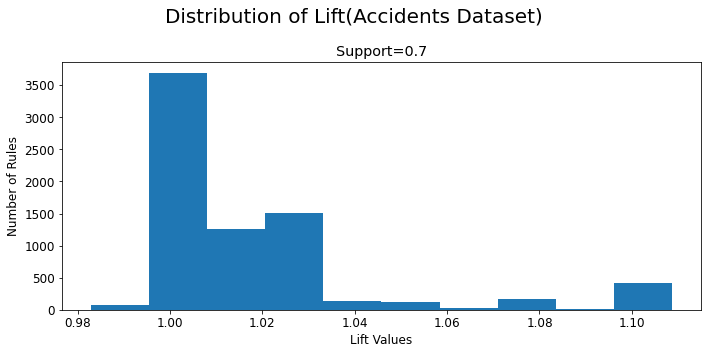

In [187]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(10,5))
axs.hist(association2[0]['lift'])
#axs[1].hist(association1[4]['lift'])
axs.set_title('Support=0.7')
#axs[1].set_title('Support=0.005')
axs.set_xlabel('Lift Values')
axs.set_ylabel('Number of Rules')
#axs[1].set_xlabel('Lift Values')
plt.suptitle('Distribution of Lift(Accidents Dataset)',fontsize=20)
plt.savefig("Distribution of Lift(Accidents Dataset).png")

### Distribution of Cosine

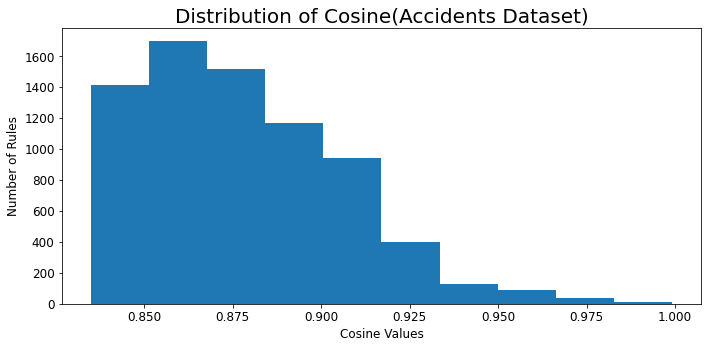

In [121]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(10,5))
axs.hist(association2[0]['Cosine'])
#axs[1].hist(association2[2]['Cosine'])
axs.set_title('Support=0.7')
#axs.set_title('Support=0.9')
axs.set_xlabel('Cosine Values')
axs.set_ylabel('Number of Rules')
#axs[1].set_xlabel('Cosine Values')
plt.title('Distribution of Cosine(Accidents Dataset)',fontsize=20)
plt.savefig('im11.PNG')

### Distribution of Kulc

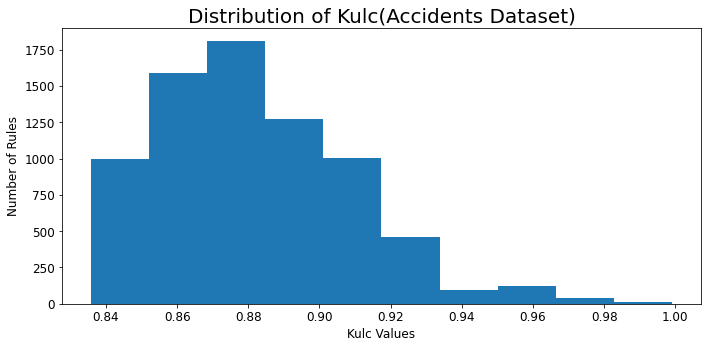

In [122]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(10,5))
axs.hist(association2[0]['Kulc'])
#axs[1].hist(association2[2]['Cosine'])
axs.set_title('Support=0.7')
#axs.set_title('Support=0.9')
axs.set_xlabel('Kulc Values')
axs.set_ylabel('Number of Rules')
#axs[1].set_xlabel('Cosine Values')
plt.title('Distribution of Kulc(Accidents Dataset)',fontsize=20)
plt.savefig('im9.PNG')

### Distribution of Coherence

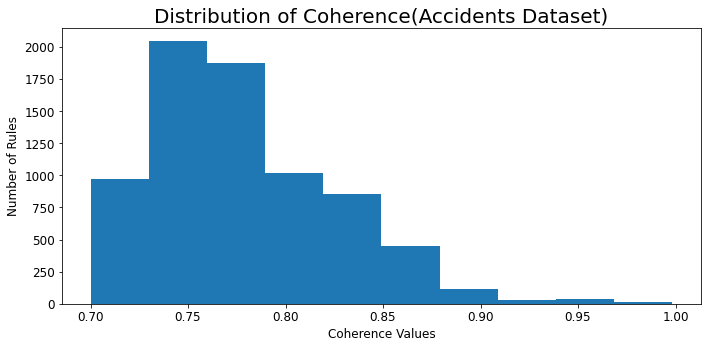

In [123]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=(10,5))
axs.hist(association2[0]['Coherence'])
#axs[1].hist(association2[2]['Cosine'])
axs.set_title('Support=0.7')
#axs.set_title('Support=0.9')
axs.set_xlabel('Coherence Values')
axs.set_ylabel('Number of Rules')
#axs[1].set_xlabel('Cosine Values')
plt.title('Distribution of Coherence(Accidents Dataset)',fontsize=20)
plt.savefig('im10.PNG')

### Contradicting Lift vs Other Measures

In [71]:
#Contradicting Rules Cosine
rules=association2[0]#Dataframe for support=0.7
pd.set_option("display.max_columns", 100)
x = rules[(rules['lift']<1) & (rules['Cosine']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf','antecedent support','consequent support'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='lift', ascending=False)
x.reset_index(drop=True, inplace=True)
x

,antecedents,consequents,support,confidence,lift,Coherence,Cosine,Kulc
0,(29),(18),0.876484,0.996677,0.999969,0.876808,0.936193,0.938028
1,"(29, 21)",(18),0.787050,0.996676,0.999968,0.787575,0.887144,0.893163
2,"(15, 21)",(12),0.713269,0.998161,0.999966,0.713619,0.844538,0.856360
3,"(18, 12)",(29),0.876026,0.879371,0.999960,0.876398,0.935944,0.937764
4,"(18, 12)",(28),0.792203,0.795228,0.999949,0.792788,0.890035,0.895686
...,...,...,...,...,...,...,...,...
121,"(12, 18)",(31),0.916507,0.920007,0.984221,0.903457,0.949761,0.950242
122,(18),(31),0.916927,0.919955,0.984166,0.903789,0.949952,0.950441
123,(31),(18),0.916927,0.980927,0.984166,0.903789,0.949952,0.950441
124,(12),(31),0.918194,0.919854,0.984058,0.904841,0.950556,0.951068


In [72]:
#Contradicting Rules Kulc
rules=association2[0]
x = rules[(rules['lift']<1) & (rules['Kulc']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
1238,(16),(12),0.977068,0.998195,0.961888,0.984464,0.986244,0.949193,0.973990,0.974046
1237,(18),(16),0.996708,0.977068,0.959957,0.963128,0.985732,0.946872,0.972759,0.972808
1236,(16),(18),0.977068,0.996708,0.959957,0.982487,0.985732,0.946872,0.972759,0.972808
1244,"(18, 12)",(16),0.996196,0.977068,0.959492,0.963156,0.985761,0.946457,0.972538,0.972584
688,(12),(31),0.998195,0.934756,0.918194,0.919854,0.984058,0.904841,0.950556,0.951068
...,...,...,...,...,...,...,...,...,...,...
1710,(15),(29),0.802177,0.879406,0.702678,0.875964,0.996086,0.717820,0.836617,0.837500
1731,"(15, 12)",(29),0.800651,0.879406,0.701343,0.875966,0.996088,0.716596,0.835823,0.836742
1732,"(29, 12)",(15),0.877904,0.802177,0.701343,0.798883,0.995894,0.716579,0.835741,0.836592
1725,"(15, 18)",(29),0.799326,0.879406,0.700088,0.875848,0.995954,0.715365,0.835018,0.835970


In [73]:
#Contradicting rules Coherence
rules=association2[0]
x = rules[(rules['lift']<1) & (rules['Coherence']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Coherence', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
1238,(16),(12),0.977068,0.998195,0.961888,0.984464,0.986244,0.949193,0.973990,0.974046
1237,(18),(16),0.996708,0.977068,0.959957,0.963128,0.985732,0.946872,0.972759,0.972808
1236,(16),(18),0.977068,0.996708,0.959957,0.982487,0.985732,0.946872,0.972759,0.972808
1244,"(18, 12)",(16),0.996196,0.977068,0.959492,0.963156,0.985761,0.946457,0.972538,0.972584
688,(12),(31),0.998195,0.934756,0.918194,0.919854,0.984058,0.904841,0.950556,0.951068
...,...,...,...,...,...,...,...,...,...,...
1746,(18),"(15, 21)",0.996708,0.714583,0.712073,0.714425,0.999779,0.712630,0.843751,0.855456
1854,"(15, 21)","(12, 18)",0.714583,0.996196,0.711776,0.996072,0.999875,0.712486,0.843616,0.855283
1855,"(12, 18)","(15, 21)",0.996196,0.714583,0.711776,0.714494,0.999875,0.712486,0.843616,0.855283
1730,"(15, 29)",(12),0.702678,0.998195,0.701343,0.998100,0.999905,0.701673,0.837422,0.850356


### Kulc vs Cosine

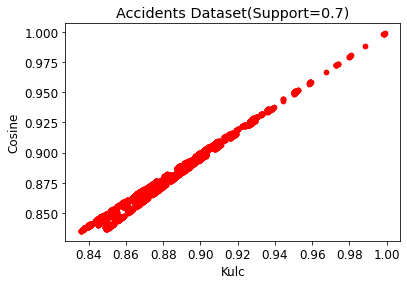

In [74]:
#CosinevsKulc
rules=association2[0]
rules.plot(kind='scatter',x='Kulc',y='Cosine',color='red')
plt.title("Accidents Dataset(Support=0.7)")
plt.show()

### Kulc vs Coherence

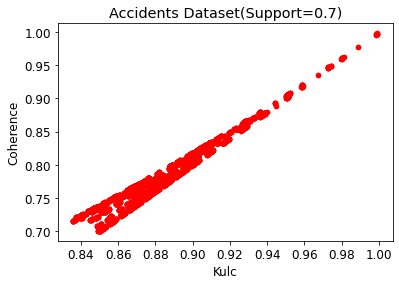

In [75]:
rules=association2[0]
rules.plot(kind='scatter',x='Kulc',y='Coherence',color='red')
plt.title("Accidents Dataset(Support=0.7)")
plt.show()

### Cosine vs Coherence

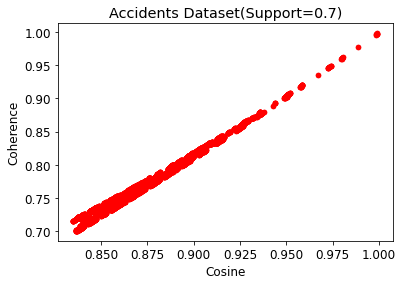

In [76]:
rules=association2[0]
rules.plot(kind='scatter',x='Cosine',y='Coherence',color='red')
plt.title("Accidents Dataset(Support=0.7)")
plt.show()

### Kulc between .3 & .7

In [77]:
#Kulc values between .7 and .3
rules=association2[0]
x = rules[(rules['Kulc']>.3) & (rules['Kulc']<.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=True)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc


### Lift vs Null Transactions

In [78]:
df=association2[0].iloc[:, :-7]
transactions=int(data.shape[0])
list1=[]
list2=[]
list3=[]
list4=[]
for index in df.index:
    list1.append(np.round(df['support'][index]*transactions))
    list2.append(np.round((df['consequent support'][index]-df['support'][index])*transactions))
    list3.append(np.round((df['antecedent support'][index]-df['support'][index])*transactions))
    list4.append(np.round(transactions-transactions*((df['antecedent support'][index]-df['support'][index])+(df['consequent support'][index]-df['support'][index]))))
df['a and b']=list1
df['not a and b']=list2
df['a and not b']=list3
df['not a and not b']=list4  
df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,a and b,not a and b,a and not b,not a and not b
0,(8),(18),0.702684,0.996708,0.700432,0.996795,1.000087,238275.0,100788.0,766.0,238629.0
1,(18),(8),0.996708,0.702684,0.700432,0.702745,1.000087,238275.0,766.0,100788.0,238629.0
2,(8),(12),0.702684,0.998195,0.701496,0.998309,1.000115,238637.0,100932.0,404.0,238847.0
3,(12),(8),0.998195,0.702684,0.701496,0.702764,1.000115,238637.0,404.0,100932.0,238847.0
4,(8),(17),0.702684,0.999906,0.702684,1.000000,1.000094,239041.0,101110.0,0.0,239073.0
...,...,...,...,...,...,...,...,...,...,...,...
7397,(21),"(18, 29, 31, 17, 16, 12)",0.888977,0.803903,0.725039,0.815588,1.014535,246646.0,26828.0,55769.0,257586.0
7398,(29),"(18, 21, 31, 17, 16, 12)",0.879406,0.803970,0.725039,0.824464,1.025492,246646.0,26851.0,52513.0,260819.0
7399,(17),"(18, 21, 29, 31, 16, 12)",0.999906,0.725039,0.725039,0.725107,1.000094,246646.0,0.0,93505.0,246678.0
7400,(16),"(18, 21, 29, 31, 17, 12)",0.977068,0.739305,0.725039,0.742056,1.003721,246646.0,4853.0,85736.0,249594.0


### Plot of Lift vs Null Transactions

Text(0.5, 1.0, 'Accidents Dataset(Support=0.7)')

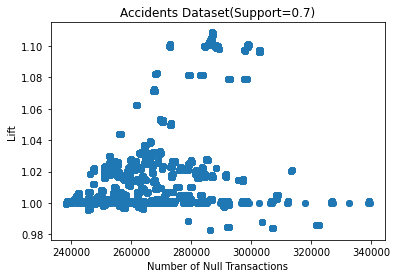

In [79]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)
plt.scatter(df["not a and not b"], df["lift"])
plt.xlabel("Number of Null Transactions")
plt.ylabel("Lift")
plt.title("Accidents Dataset(Support=0.7)")

# Mushroom Dataset

In [80]:
a_file = open("Mushroom.txt", "r")
data = []
for line in a_file:
    stripped_line= line.strip()
    line_list = stripped_line.split()
    data.append(list(line_list))
a_file.close()
data=np.array(data)
te_ary = te.fit(data).transform(data)
dfr = pd.DataFrame(te_ary, columns=te.columns_)

### Generating rules for different support

In [81]:
association3=[]#For storing dataframe of rules for different support
noofitems3=[]#For storing number of itemset for different support
noofrules3=[]#For storing number of rules for different support
for i in [.3,.4,.5,.6,.7,.8,.9]:
    te_ary = te.fit(data).transform(data)
    dfr = pd.DataFrame(te_ary, columns=te.columns_)
    df=fpgrowth(dfr, min_support=i,use_colnames=True)
    associationrule = association_rules(df, metric="confidence", min_threshold=0)
    associationrule=measures(associationrule)
    association3.append(associationrule)
    noofitems3.append(df.shape[0])
    noofrules3.append(associationrule.shape[0])   

In [82]:
noofitems3

[2735, 565, 153, 51, 31, 23, 9]

In [83]:
noofrules3

[94894, 7020, 1148, 266, 180, 88, 14]

### Plot of itemsets vs number of rules

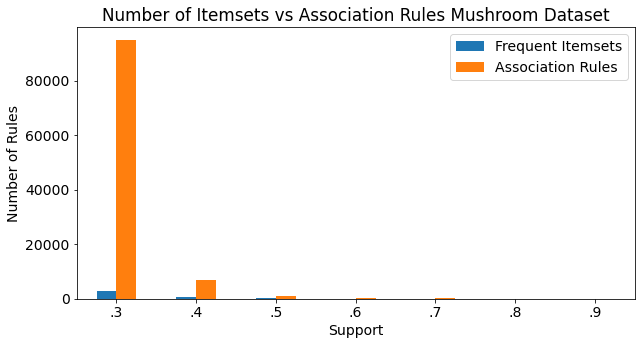

In [84]:
X = ['.3','.4','.5','.6','.7','.8','.9']
index = X
df = pd.DataFrame({'Frequent Itemsets': noofitems3,
                   'Association Rules': noofrules3}, index=index)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
ax = df.plot.bar(rot=0,figsize=(10, 5))
plt.xlabel("Support")
plt.ylabel("Number of Rules")
plt.title("Number of Itemsets vs Association Rules Mushroom Dataset")
plt.savefig("FreqItemmsvsRules-Mushroom.png")

### Finding number of confident and misleading rules

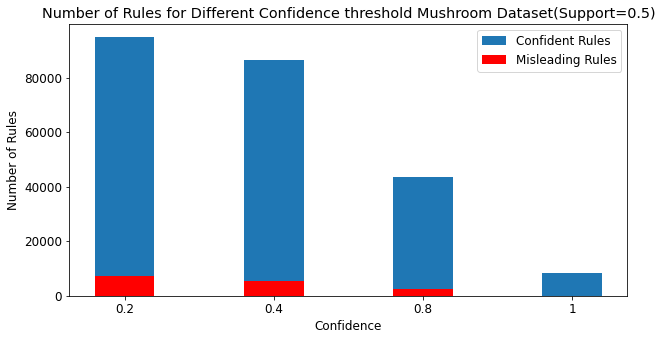

In [85]:
rules=association3[0]#Dataframe for support=0.5
tempconf=[]
misrules=[]
for conf in [.2,.4,.8,1]:
        x = rules[rules['confidence']>=conf]
        tempconf.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['confidence']<rules['consequent support'])]
        misrules.append(x.shape[0])
X = ['0.2','0.4','0.8','1']
X_axis = np.arange(len(X))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.figure(figsize=(10,5))
plt.bar(X_axis, tempconf, 0.4,label='Confident Rules')
plt.bar(X_axis, misrules, 0.4,color='r',label='Misleading Rules')
plt.xticks(X_axis, X)
plt.xlabel("Confidence")
plt.ylabel("Number of Rules")
plt.title("Number of Rules for Different Confidence threshold Mushroom Dataset"+"("+"Support=0.5"+")")
plt.legend()
plt.savefig("Mushroom-Misleading.png")
plt.show()

### Top 20 misleading rules by Confidence

In [86]:
#Misleading rules for support=0.5 and conf=0.2
rules=association3[0]#Dataframe for support=0.5
x = rules[(rules['confidence']>=0.2) & (rules['confidence']<rules['consequent support'])].iloc[:, :-8].nlargest(20,'confidence',keep='all')
x

,antecedents,consequents,antecedent support,consequent support,support,confidence
90338,"(36, 110)",(86),0.473658,0.975382,0.461841,0.975052
90364,"(36, 85, 110)",(86),0.473658,0.975382,0.461841,0.975052
90371,"(36, 110)","(86, 85)",0.473658,0.975382,0.461841,0.975052
90379,"(36, 90, 110)",(86),0.462826,0.975382,0.451009,0.974468
90393,"(36, 85, 90, 110)",(86),0.462826,0.975382,0.451009,0.974468
90404,"(36, 90, 110)","(86, 85)",0.462826,0.975382,0.451009,0.974468
17,(90),(86),0.921713,0.975382,0.897095,0.973291
26,"(85, 90)",(86),0.921713,0.975382,0.897095,0.973291
29,(90),"(86, 85)",0.921713,0.975382,0.897095,0.973291
53,(36),(86),0.838503,0.975382,0.814870,0.971814


### Number of Lift Rules for different confidence threshold

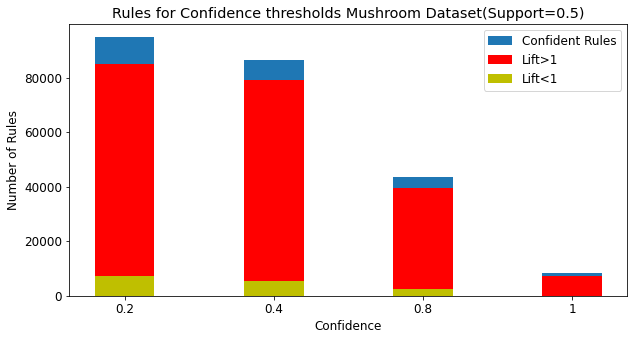

In [87]:
rules=association3[0]#Dataframe for support=0.5
tempconf=[]
liftrules=[]
liftrulesneg=[]
for conf in [.2,.4,.8,1]:
        x = rules[rules['confidence']>=conf]
        tempconf.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['lift']>1)]
        liftrules.append(x.shape[0])
        x = rules[(rules['confidence']>=conf) & (rules['lift']<1)]
        liftrulesneg.append(x.shape[0])
X = ['0.2','0.4','0.8','1']
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
X_axis = np.arange(len(X))
plt.figure(figsize=(10,5))
plt.bar(X_axis, tempconf, 0.4,label='Confident Rules')
plt.bar(X_axis, liftrules, 0.4,color='r',label='Lift>1')
plt.bar(X_axis, liftrulesneg, 0.4,color='y',label='Lift<1')
plt.xticks(X_axis, X)
plt.xlabel("Confidence")
plt.ylabel("Number of Rules")
plt.title("Rules for Confidence thresholds Mushroom Dataset"+"("+"Support=0.5"+")")
plt.legend()
plt.savefig("ConfMis.png")
plt.show()

### Top 20 misleading rules and their lift values

In [88]:
#Misleading rules for support=0.5 and conf=0.2
rules=association3[0]
x = rules[(rules['confidence']>=0.2) & (rules['confidence']<rules['consequent support'])].iloc[:, :-7].nlargest(20,'confidence',keep='all')
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
90338,"(36, 110)",(86),0.473658,0.975382,0.461841,0.975052,0.999662
90364,"(36, 85, 110)",(86),0.473658,0.975382,0.461841,0.975052,0.999662
90371,"(36, 110)","(86, 85)",0.473658,0.975382,0.461841,0.975052,0.999662
90379,"(36, 90, 110)",(86),0.462826,0.975382,0.451009,0.974468,0.999063
90393,"(36, 85, 90, 110)",(86),0.462826,0.975382,0.451009,0.974468,0.999063
90404,"(36, 90, 110)","(86, 85)",0.462826,0.975382,0.451009,0.974468,0.999063
17,(90),(86),0.921713,0.975382,0.897095,0.973291,0.997856
26,"(85, 90)",(86),0.921713,0.975382,0.897095,0.973291,0.997856
29,(90),"(86, 85)",0.921713,0.975382,0.897095,0.973291,0.997856
53,(36),(86),0.838503,0.975382,0.814870,0.971814,0.996343


### Distribution of Lift

Text(0.5, 0.98, 'Distribution of Lift(Mushroom Dataset)')

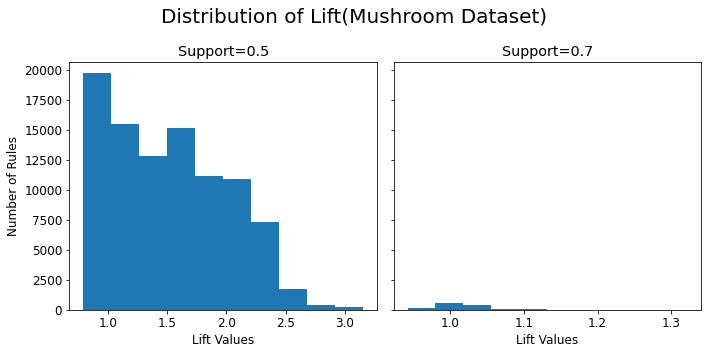

In [89]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(10,5))
axs[0].hist(association3[0]['lift'])
axs[1].hist(association3[2]['lift'])
axs[0].set_title('Support=0.5')
axs[1].set_title('Support=0.7')
axs[0].set_xlabel('Lift Values')
axs[0].set_ylabel('Number of Rules')
axs[1].set_xlabel('Lift Values')
plt.suptitle('Distribution of Lift(Mushroom Dataset)',fontsize=20)

### Distribution of Cosine

Text(0.5, 0.98, 'Distribution of Cosine(Mushroom Dataset)')

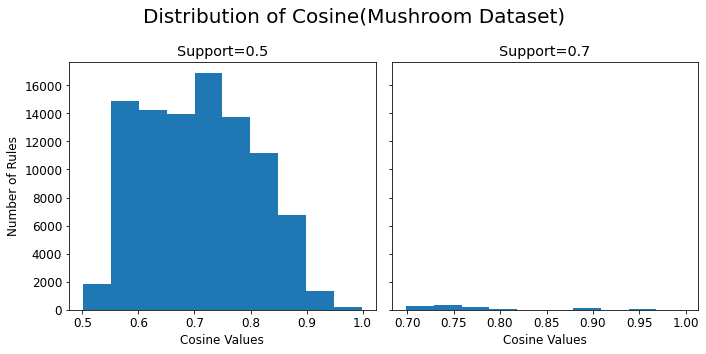

In [90]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(10,5))
axs[0].hist(association3[0]['Cosine'])
axs[1].hist(association3[2]['Cosine'])
axs[0].set_title('Support=0.5')
axs[1].set_title('Support=0.7')
axs[0].set_xlabel('Cosine Values')
axs[0].set_ylabel('Number of Rules')
axs[1].set_xlabel('Cosine Values')
plt.suptitle('Distribution of Cosine(Mushroom Dataset)',fontsize=20)

### Distribution of Kulc

Text(0.5, 0.98, 'Distribution of Kulc(Mushroom Dataset)')

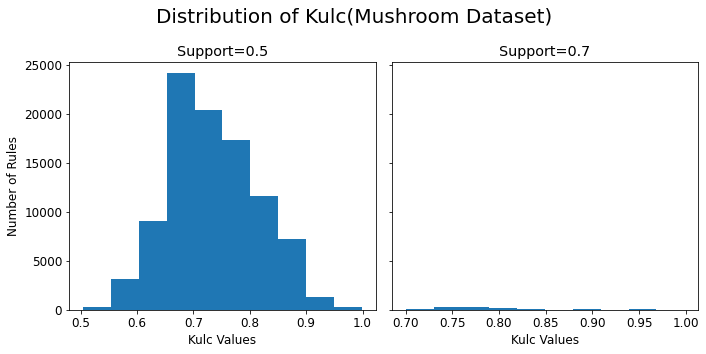

In [91]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(10,5))
axs[0].hist(association3[0]['Kulc'])
axs[1].hist(association3[2]['Kulc'])
axs[0].set_title('Support=0.5')
axs[1].set_title('Support=0.7')
axs[0].set_xlabel('Kulc Values')
axs[0].set_ylabel('Number of Rules')
axs[1].set_xlabel('Kulc Values')
plt.suptitle('Distribution of Kulc(Mushroom Dataset)',fontsize=20)

### Distribution of Coherence

Text(0.5, 0.98, 'Distribution of Coherence(Mushroom Dataset)')

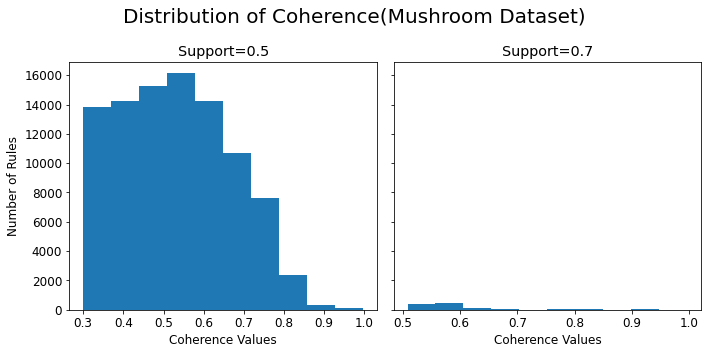

In [92]:
font = {'family' : 'normal','weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(10,5))
axs[0].hist(association3[0]['Coherence'])
axs[1].hist(association3[2]['Coherence'])
axs[0].set_title('Support=0.5')
axs[1].set_title('Support=0.7')
axs[0].set_xlabel('Coherence Values')
axs[0].set_ylabel('Number of Rules')
axs[1].set_xlabel('Coherence Values')
plt.suptitle('Distribution of Coherence(Mushroom Dataset)',fontsize=20)

### Contradicting Lift vs Other Measures

In [93]:
#Contradicting Rules Kulc
rules=association3[0]
x = rules[(rules['lift']<1) & (rules['Kulc']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
16,(86),(90),0.975382,0.921713,0.897095,0.919738,0.997856,0.897095,0.946135,0.946514
52,(86),(36),0.975382,0.838503,0.814870,0.835437,0.996343,0.815673,0.901049,0.903626
65,"(86, 34)",(36),0.973166,0.838503,0.812654,0.835062,0.995896,0.813455,0.899621,0.902117
68,(36),"(86, 34)",0.838503,0.973166,0.812654,0.969172,0.995896,0.813455,0.899621,0.902117
54,(36),(34),0.838503,0.974151,0.812654,0.969172,0.994889,0.812654,0.899167,0.901695
...,...,...,...,...,...,...,...,...,...,...
2149,"(63, 59, 90)","(86, 34)",0.466273,0.973166,0.442639,0.949314,0.975490,0.444060,0.657107,0.702079
2052,"(63, 59, 90)",(34),0.466273,0.974151,0.442639,0.949314,0.974504,0.443622,0.656775,0.701849
2068,"(63, 59, 90)",(86),0.466273,0.975382,0.442639,0.949314,0.973274,0.443075,0.656361,0.701562
69664,(39),"(36, 90)",0.690793,0.795667,0.517971,0.749822,0.942381,0.534825,0.698661,0.700406


In [94]:
#Contradicting Rules Cosine
rules=association3[0]
x = rules[(rules['lift']<1) & (rules['Cosine']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
16,(86),(90),0.975382,0.921713,0.897095,0.919738,0.997856,0.897095,0.946135,0.946514
52,(86),(36),0.975382,0.838503,0.814870,0.835437,0.996343,0.815673,0.901049,0.903626
65,"(86, 34)",(36),0.973166,0.838503,0.812654,0.835062,0.995896,0.813455,0.899621,0.902117
68,(36),"(86, 34)",0.838503,0.973166,0.812654,0.969172,0.995896,0.813455,0.899621,0.902117
54,(36),(34),0.838503,0.974151,0.812654,0.969172,0.994889,0.812654,0.899167,0.901695
...,...,...,...,...,...,...,...,...,...,...
78978,"(86, 34)","(90, 24)",0.973166,0.542590,0.517971,0.532254,0.980951,0.519122,0.712815,0.743441
78983,"(90, 24)","(86, 34)",0.542590,0.973166,0.517971,0.954628,0.980951,0.519122,0.712815,0.743441
78942,"(90, 24)",(86),0.542590,0.975382,0.517971,0.954628,0.978723,0.517971,0.712004,0.742836
69766,"(86, 36, 39)",(90),0.537174,0.921713,0.494338,0.920257,0.998419,0.512506,0.702536,0.728291


In [95]:
#Contradicting Rules Coherence
rules=association3[0]
x = rules[(rules['lift']<1) & (rules['Coherence']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Coherence', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
16,(86),(90),0.975382,0.921713,0.897095,0.919738,0.997856,0.897095,0.946135,0.946514
52,(86),(36),0.975382,0.838503,0.814870,0.835437,0.996343,0.815673,0.901049,0.903626
65,"(86, 34)",(36),0.973166,0.838503,0.812654,0.835062,0.995896,0.813455,0.899621,0.902117
68,(36),"(86, 34)",0.838503,0.973166,0.812654,0.969172,0.995896,0.813455,0.899621,0.902117
54,(36),(34),0.838503,0.974151,0.812654,0.969172,0.994889,0.812654,0.899167,0.901695
55,(34),(36),0.974151,0.838503,0.812654,0.834218,0.994889,0.812654,0.899167,0.901695
141,"(86, 34)","(36, 90)",0.973166,0.795667,0.772033,0.793322,0.997052,0.774512,0.877358,0.881809
97,"(36, 90)",(34),0.795667,0.974151,0.772033,0.970297,0.996044,0.773748,0.876915,0.881408
104,"(36, 90)",(86),0.795667,0.975382,0.772033,0.970297,0.994787,0.772794,0.876361,0.880908


### CosinevsKulc

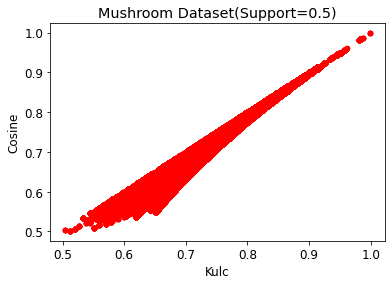

In [96]:
#CosinevsKulc
rules=association3[0]
rules.plot(kind='scatter',x='Kulc',y='Cosine',color='red')
plt.title("Mushroom Dataset(Support=0.5)")
plt.show()

### CoherencevsKulc

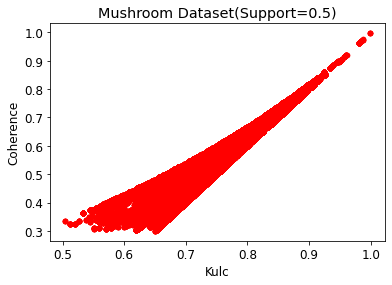

In [97]:
#CoherencevsKulc
rules=association3[0]
rules.plot(kind='scatter',x='Kulc',y='Coherence',color='red')
plt.title("Mushroom Dataset(Support=0.5)")
plt.show()

### CosinevsCoherence

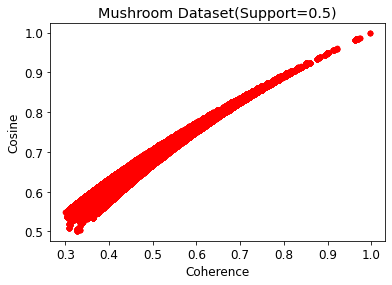

In [98]:
#CosinevsCoherence
rules=association3[0]
rules.plot(kind='scatter',x='Coherence',y='Cosine',color='red')
plt.title("Mushroom Dataset(Support=0.5)")
plt.show()

### Total Contradicting Rules for Different Datasets

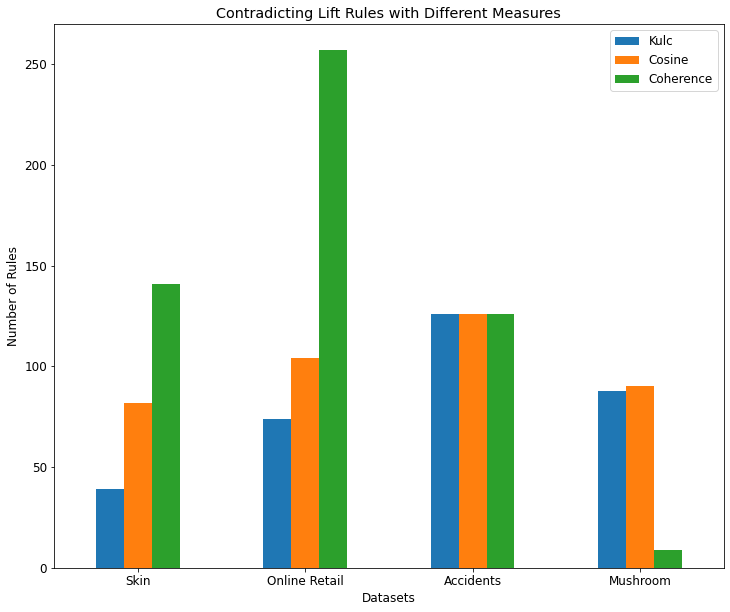

In [99]:
kulc=[39,74,126,88]
cosine=[82,104,126,90]
coherence=[141,257,126,9]
totalrule=[association[4].shape[0],association1[4].shape[0],association2[0].shape[0],association3[0].shape[0]]
X = ['Skin','Online Retail','Accidents','Mushroom']
index = X
df = pd.DataFrame({
                   'Kulc': kulc,'Cosine':cosine,'Coherence':coherence}, index=index)
ax = df.plot.bar(rot=0,figsize=(12, 10))
plt.xlabel("Datasets")
plt.ylabel("Number of Rules")
plt.title("Contradicting Lift Rules with Different Measures")
plt.savefig("ContradictingRules.png")

### Ranking Rules for Skin Dataset

In [100]:
rules=association[4]
rules=rules.nlargest(20,'Kulc',keep='all')
rules=rules.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
rules=rules.drop_duplicates(subset=['Kulc']).sort_values(by='Kulc', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
488,"(11, 1)",(4),0.231456,0.234733,0.207017,0.894412,3.810337,0.798763,0.888147,0.888169
306,"(6, 8)","(11, 3)",0.236357,0.302240,0.232183,0.982340,3.250199,0.757743,0.868701,0.875274
278,"(6, 8)",(3),0.236357,0.317110,0.232183,0.982340,3.097790,0.722672,0.848089,0.857262
596,"(4, 11)","(1, 7)",0.226425,0.180627,0.171785,0.758684,4.200280,0.730170,0.849438,0.854866
284,"(6, 11)",(3),0.304133,0.317110,0.264028,0.868133,2.737641,0.739129,0.850185,0.850370
598,"(4, 7)","(11, 1)",0.180166,0.231456,0.171785,0.953482,4.119495,0.716257,0.841230,0.847837
576,"(1, 7)",(4),0.180627,0.234733,0.171785,0.951048,4.051617,0.705265,0.834270,0.841440
6,(4),(1),0.234733,0.289578,0.215325,0.917319,3.167778,0.696876,0.825895,0.830450


In [101]:
rules=association[4]
rules=rules.nlargest(20,'Cosine',keep='all')
rules=rules.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
rules=rules.drop_duplicates(subset=['Cosine']).sort_values(by='Cosine', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
488,"(11, 1)",(4),0.231456,0.234733,0.207017,0.894412,3.810337,0.798763,0.888147,0.888169
306,"(6, 8)","(11, 3)",0.236357,0.302240,0.232183,0.982340,3.250199,0.757743,0.868701,0.875274
284,"(6, 11)",(3),0.304133,0.317110,0.264028,0.868133,2.737641,0.739129,0.850185,0.850370
596,"(4, 11)","(1, 7)",0.226425,0.180627,0.171785,0.758684,4.200280,0.730170,0.849438,0.854866
278,"(6, 8)",(3),0.236357,0.317110,0.232183,0.982340,3.097790,0.722672,0.848089,0.857262
598,"(4, 7)","(11, 1)",0.180166,0.231456,0.171785,0.953482,4.119495,0.716257,0.841230,0.847837
576,"(1, 7)",(4),0.180627,0.234733,0.171785,0.951048,4.051617,0.705265,0.834270,0.841440
308,"(6, 11)","(8, 3)",0.304133,0.259213,0.232183,0.763426,2.945168,0.701114,0.826933,0.829574


In [102]:
rules=association[4]
rules=rules.nlargest(20,'Coherence',keep='all')
rules=rules.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
rules=rules.drop_duplicates(subset=['Coherence']).sort_values(by='Coherence', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
488,"(11, 1)",(4),0.231456,0.234733,0.207017,0.894412,3.810337,0.798763,0.888147,0.888169
306,"(6, 8)","(11, 3)",0.236357,0.302240,0.232183,0.982340,3.250199,0.757743,0.868701,0.875274
284,"(6, 11)",(3),0.304133,0.317110,0.264028,0.868133,2.737641,0.739129,0.850185,0.850370
596,"(4, 11)","(1, 7)",0.226425,0.180627,0.171785,0.758684,4.200280,0.730170,0.849438,0.854866
278,"(6, 8)",(3),0.236357,0.317110,0.232183,0.982340,3.097790,0.722672,0.848089,0.857262
598,"(4, 7)","(11, 1)",0.180166,0.231456,0.171785,0.953482,4.119495,0.716257,0.841230,0.847837
576,"(1, 7)",(4),0.180627,0.234733,0.171785,0.951048,4.051617,0.705265,0.834270,0.841440
308,"(6, 11)","(8, 3)",0.304133,0.259213,0.232183,0.763426,2.945168,0.701114,0.826933,0.829574


### Ranking Rules for OnlineRetail Dataset

In [103]:
rules=association1[4]
rules=rules.nlargest(20,'Kulc',keep='all')
rules=rules.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
rules=rules.drop_duplicates(subset=['Kulc']).sort_values(by='Kulc', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
191,"(1989, 951)","(1394, 324)",0.005261,0.005261,0.005261,1.000000,190.077932,1.000000,1.000000,1.000000
262,(169),(229),0.007525,0.007359,0.007359,0.977940,132.890365,0.977940,0.988909,0.988970
84,"(349, 1142)",(2363),0.015811,0.016678,0.015811,1.000000,59.959228,0.948015,0.973661,0.974008
374,"(1605, 1235)",(490),0.005307,0.005693,0.005307,1.000000,175.654312,0.932197,0.965504,0.966099
85,"(349, 2363)",(1142),0.015811,0.017508,0.015811,1.000000,57.116747,0.903073,0.950301,0.951536
578,"(1165, 2231)",(1703),0.007904,0.006889,0.006889,0.871584,126.518219,0.871584,0.933587,0.935792
78,(1142),(2363),0.017508,0.016678,0.015811,0.903073,54.147553,0.860463,0.925271,0.925544


In [104]:
rules=association1[4]
rules=rules.nlargest(20,'Cosine',keep='all')
rules=rules.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
rules=rules.drop_duplicates(subset=['Cosine']).sort_values(by='Cosine', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
191,"(1989, 951)","(1394, 324)",0.005261,0.005261,0.005261,1.000000,190.077932,1.000000,1.000000,1.000000
262,(169),(229),0.007525,0.007359,0.007359,0.977940,132.890365,0.977940,0.988909,0.988970
84,"(349, 1142)",(2363),0.015811,0.016678,0.015811,1.000000,59.959228,0.948015,0.973661,0.974008
374,"(1605, 1235)",(490),0.005307,0.005693,0.005307,1.000000,175.654312,0.932197,0.965504,0.966099
85,"(349, 2363)",(1142),0.015811,0.017508,0.015811,1.000000,57.116747,0.903073,0.950301,0.951536
578,"(1165, 2231)",(1703),0.007904,0.006889,0.006889,0.871584,126.518219,0.871584,0.933587,0.935792
78,(1142),(2363),0.017508,0.016678,0.015811,0.903073,54.147553,0.860463,0.925271,0.925544


In [105]:
rules=association1[4]
rules=rules.nlargest(20,'Coherence',keep='all')
rules=rules.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
rules=rules.drop_duplicates(subset=['Coherence']).sort_values(by='Coherence', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
191,"(1989, 951)","(1394, 324)",0.005261,0.005261,0.005261,1.000000,190.077932,1.000000,1.000000,1.000000
262,(169),(229),0.007525,0.007359,0.007359,0.977940,132.890365,0.977940,0.988909,0.988970
84,"(349, 1142)",(2363),0.015811,0.016678,0.015811,1.000000,59.959228,0.948015,0.973661,0.974008
374,"(1605, 1235)",(490),0.005307,0.005693,0.005307,1.000000,175.654312,0.932197,0.965504,0.966099
85,"(349, 2363)",(1142),0.015811,0.017508,0.015811,1.000000,57.116747,0.903073,0.950301,0.951536
578,"(1165, 2231)",(1703),0.007904,0.006889,0.006889,0.871584,126.518219,0.871584,0.933587,0.935792
78,(1142),(2363),0.017508,0.016678,0.015811,0.903073,54.147553,0.860463,0.925271,0.925544


### Ranking Rules for Accidents

In [106]:
rules=association2[0]
rules=rules.nlargest(20,'Kulc',keep='all')
rules=rules.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
rules=rules.drop_duplicates(subset=['Kulc']).sort_values(by='Kulc', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
1286,(12),(17),0.998195,0.999906,0.998195,1.000000,1.000094,0.998289,0.999144,0.999144
1276,(12),(18),0.998195,0.996708,0.996196,0.997997,1.001294,0.997486,0.998742,0.998742
1278,(18),(17),0.996708,0.999906,0.996708,1.000000,1.000094,0.996802,0.998400,0.998401
1280,"(18, 12)",(17),0.996196,0.999906,0.996196,1.000000,1.000094,0.996290,0.998143,0.998145
1240,(16),(17),0.977068,0.999906,0.977068,1.000000,1.000094,0.977160,0.988514,0.988580
1254,"(16, 12)",(17),0.961888,0.999906,0.961888,1.000000,1.000094,0.961978,0.980805,0.980989
1243,"(16, 18)",(12),0.959957,0.998195,0.959492,0.999516,1.001323,0.960779,0.980184,0.980371


In [107]:
rules=association2[0]
rules=rules.nlargest(20,'Cosine',keep='all')
rules=rules.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
rules=rules.drop_duplicates(subset=['Cosine']).sort_values(by='Cosine', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
1286,(12),(17),0.998195,0.999906,0.998195,1.000000,1.000094,0.998289,0.999144,0.999144
1276,(12),(18),0.998195,0.996708,0.996196,0.997997,1.001294,0.997486,0.998742,0.998742
1278,(18),(17),0.996708,0.999906,0.996708,1.000000,1.000094,0.996802,0.998400,0.998401
1280,"(18, 12)",(17),0.996196,0.999906,0.996196,1.000000,1.000094,0.996290,0.998143,0.998145
1240,(16),(17),0.977068,0.999906,0.977068,1.000000,1.000094,0.977160,0.988514,0.988580
1254,"(16, 12)",(17),0.961888,0.999906,0.961888,1.000000,1.000094,0.961978,0.980805,0.980989
1243,"(16, 18)",(12),0.959957,0.998195,0.959492,0.999516,1.001323,0.960779,0.980184,0.980371


In [108]:
rules=association2[0]
rules=rules.nlargest(20,'Coherence',keep='all')
rules=rules.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
rules=rules.drop_duplicates(subset=['Coherence']).sort_values(by='Coherence', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
1286,(12),(17),0.998195,0.999906,0.998195,1.000000,1.000094,0.998289,0.999144,0.999144
1276,(12),(18),0.998195,0.996708,0.996196,0.997997,1.001294,0.997486,0.998742,0.998742
1278,(18),(17),0.996708,0.999906,0.996708,1.000000,1.000094,0.996802,0.998400,0.998401
1280,"(18, 12)",(17),0.996196,0.999906,0.996196,1.000000,1.000094,0.996290,0.998143,0.998145
1240,(16),(17),0.977068,0.999906,0.977068,1.000000,1.000094,0.977160,0.988514,0.988580
1254,"(16, 12)",(17),0.961888,0.999906,0.961888,1.000000,1.000094,0.961978,0.980805,0.980989
1243,"(16, 18)",(12),0.959957,0.998195,0.959492,0.999516,1.001323,0.960779,0.980184,0.980371


In [109]:
itemname=pd.read_excel("OnlineRetailZZAtrributes.xlsx",header=None)
t=list(itemname[0])
t

["'!'",
 "'&'",
 "'''N'''",
 "'(22467)'",
 "'(22719)'",
 "'*Boombox'",
 "'*USB'",
 "'+'",
 "','",
 "',MAGIC'",
 "',PUDDINGS'",
 "'-'",
 "'-PAPER'",
 "'/'",
 "'0'",
 "'1'",
 "'1.8M'",
 "'10'",
 "'10/11/2010'",
 "'11'",
 "'12'",
 "'120CM'",
 "'125g'",
 "'15'",
 "'15C'",
 "'15CM'",
 "'16'",
 "'16954'",
 "'16955'",
 "'16956'",
 "'16957'",
 "'16960'",
 "'16961'",
 "'16963'",
 "'16965'",
 "'16X16CM'",
 "'17058'",
 "'17059'",
 "'17065'",
 "'17067'",
 "'17068'",
 "'17070'",
 "'17071'",
 "'17074'",
 "'17076'",
 "'17077'",
 "'17080'",
 "'17081'",
 "'17084'",
 "'17086'",
 "'17087'",
 "'17089'",
 "'17090'",
 "'17093'",
 "'17095'",
 "'17096'",
 "'17097'",
 "'17099'",
 "'17100'",
 "'17104'",
 "'17107'",
 "'17112'",
 "'17116'",
 "'17211'",
 "'17214'",
 "'17216'",
 "'17217'",
 "'17218'",
 "'17219'",
 "'17220'",
 "'17259'",
 "'17262'",
 "'1800'",
 "'18PC'",
 "'2'",
 "'20'",
 "'200'",
 "'20713'",
 "'20LIGHT'",
 "'21'",
 "'21/5/10'",
 "'22467'",
 "'22804'",
 "'23'",
 "'23343'",
 "'24'",
 "'250g'",
 "'25W

In [110]:
rules=association[4]
x = rules[(rules['Kulc']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
#x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
6,(4),(1),0.234733,0.289578,0.215325,0.917319,3.167778,0.696876,0.825895,0.830450
7,(1),(4),0.289578,0.234733,0.215325,0.743582,3.167778,0.696876,0.825895,0.830450
88,(10),(9),0.207539,0.232460,0.161191,0.776678,3.341126,0.578143,0.733866,0.735046
89,(9),(10),0.232460,0.207539,0.161191,0.693414,3.341126,0.578143,0.733866,0.735046
107,"(10, 2)",(9),0.134548,0.232460,0.128994,0.958721,4.124241,0.541960,0.729385,0.756815
...,...,...,...,...,...,...,...,...,...,...
600,"(11, 7)","(4, 1)",0.247049,0.215325,0.171785,0.695348,3.229295,0.591161,0.744812,0.746571
601,"(1, 7)","(4, 11)",0.180627,0.226425,0.171785,0.951048,4.200280,0.730170,0.849438,0.854866
602,(4),"(11, 1, 7)",0.234733,0.180627,0.171785,0.731831,4.051617,0.705265,0.834270,0.841440
604,(1),"(4, 11, 7)",0.289578,0.180166,0.171785,0.593225,3.292660,0.576539,0.752083,0.773354


In [111]:
rules=association[4]
x = rules[(rules['Kulc']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
#x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
0,(4),(10),0.234733,0.207539,0.008308,0.035393,0.170539,0.019144,0.037641,0.037712
1,(10),(4),0.207539,0.234733,0.008308,0.040031,0.170539,0.019144,0.037641,0.037712
2,(10),(1),0.207539,0.289578,0.058121,0.280049,0.967092,0.132395,0.237083,0.240379
3,(1),(10),0.289578,0.207539,0.058121,0.200709,0.967092,0.132395,0.237083,0.240379
4,(10),(8),0.207539,0.493808,0.046348,0.223322,0.452244,0.070760,0.144778,0.158590
...,...,...,...,...,...,...,...,...,...,...
693,(0),(6),0.013209,0.366364,0.006117,0.463093,1.264025,0.016379,0.087932,0.239895
694,"(6, 11)",(0),0.304133,0.013209,0.006117,0.020113,1.522667,0.019655,0.096510,0.241603
696,"(11, 0)",(6),0.013209,0.366364,0.006117,0.463093,1.264025,0.016379,0.087932,0.239895
697,(6),"(11, 0)",0.366364,0.013209,0.006117,0.016697,1.264025,0.016379,0.087932,0.239895


In [112]:
rules=association[4]
x = rules[(rules['Cosine']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
#x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
6,(4),(1),0.234733,0.289578,0.215325,0.917319,3.167778,0.696876,0.825895,0.830450
7,(1),(4),0.289578,0.234733,0.215325,0.743582,3.167778,0.696876,0.825895,0.830450
88,(10),(9),0.207539,0.232460,0.161191,0.776678,3.341126,0.578143,0.733866,0.735046
89,(9),(10),0.232460,0.207539,0.161191,0.693414,3.341126,0.578143,0.733866,0.735046
107,"(10, 2)",(9),0.134548,0.232460,0.128994,0.958721,4.124241,0.541960,0.729385,0.756815
...,...,...,...,...,...,...,...,...,...,...
600,"(11, 7)","(4, 1)",0.247049,0.215325,0.171785,0.695348,3.229295,0.591161,0.744812,0.746571
601,"(1, 7)","(4, 11)",0.180627,0.226425,0.171785,0.951048,4.200280,0.730170,0.849438,0.854866
602,(4),"(11, 1, 7)",0.234733,0.180627,0.171785,0.731831,4.051617,0.705265,0.834270,0.841440
604,(1),"(4, 11, 7)",0.289578,0.180166,0.171785,0.593225,3.292660,0.576539,0.752083,0.773354


In [113]:
rules=association[4]
x = rules[(rules['Cosine']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
#x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
0,(4),(10),0.234733,0.207539,0.008308,0.035393,0.170539,0.019144,0.037641,0.037712
1,(10),(4),0.207539,0.234733,0.008308,0.040031,0.170539,0.019144,0.037641,0.037712
2,(10),(1),0.207539,0.289578,0.058121,0.280049,0.967092,0.132395,0.237083,0.240379
3,(1),(10),0.289578,0.207539,0.058121,0.200709,0.967092,0.132395,0.237083,0.240379
4,(10),(8),0.207539,0.493808,0.046348,0.223322,0.452244,0.070760,0.144778,0.158590
...,...,...,...,...,...,...,...,...,...,...
695,"(6, 0)",(11),0.006117,0.792461,0.006117,1.000000,1.261892,0.007719,0.087858,0.503859
696,"(11, 0)",(6),0.013209,0.366364,0.006117,0.463093,1.264025,0.016379,0.087932,0.239895
697,(6),"(11, 0)",0.366364,0.013209,0.006117,0.016697,1.264025,0.016379,0.087932,0.239895
698,(11),"(6, 0)",0.792461,0.006117,0.006117,0.007719,1.261892,0.007719,0.087858,0.503859


In [114]:
rules=association[4]
x = rules[(rules['Coherence']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
#x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
x.shape

(20, 10)

In [115]:
rules=association[4]
x = rules[(rules['Coherence']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
#x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
0,(4),(10),0.234733,0.207539,0.008308,0.035393,0.170539,0.019144,0.037641,0.037712
1,(10),(4),0.207539,0.234733,0.008308,0.040031,0.170539,0.019144,0.037641,0.037712
2,(10),(1),0.207539,0.289578,0.058121,0.280049,0.967092,0.132395,0.237083,0.240379
3,(1),(10),0.289578,0.207539,0.058121,0.200709,0.967092,0.132395,0.237083,0.240379
4,(10),(8),0.207539,0.493808,0.046348,0.223322,0.452244,0.070760,0.144778,0.158590
...,...,...,...,...,...,...,...,...,...,...
695,"(6, 0)",(11),0.006117,0.792461,0.006117,1.000000,1.261892,0.007719,0.087858,0.503859
696,"(11, 0)",(6),0.013209,0.366364,0.006117,0.463093,1.264025,0.016379,0.087932,0.239895
697,(6),"(11, 0)",0.366364,0.013209,0.006117,0.016697,1.264025,0.016379,0.087932,0.239895
698,(11),"(6, 0)",0.792461,0.006117,0.006117,0.007719,1.261892,0.007719,0.087858,0.503859


In [116]:
rules=association3[0]
x = rules[(rules['Coherence']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
#x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
x.shape

(13338, 10)

In [117]:
rules=association3[0]
x = rules[(rules['Coherence']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
#x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
x.shape

(0, 10)

In [118]:
association3[0].shape

(94894, 14)

In [138]:
x=association[0]
x=x[(x['Kulc']<.7)]
x=x[(x['Kulc']>.3)]
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['Kulc'])
x.drop(x.iloc[:, 2:7], inplace = True, axis = 1)
x

,antecedents,consequents,Coherence,Cosine,Kulc
12,"(4, 10)",(1),0.028690,0.169381,0.514345
18,"(4, 10)",(8),0.016824,0.129709,0.508412
24,"(10, 1)",(8),0.079813,0.240803,0.392255
25,"(10, 8)",(1),0.138227,0.352135,0.510533
26,"(8, 1)",(10),0.188900,0.403645,0.512723
...,...,...,...,...,...
1034,"(9, 0)",(11),0.005824,0.076313,0.502912
1040,"(0, 3)",(11),0.005207,0.072157,0.502603
1047,"(9, 0, 3)",(11),0.002446,0.049452,0.501223
1064,"(6, 9, 0)",(11),0.001596,0.039954,0.500798


In [137]:
x=association[0]
x=x[(x['Cosine']<.7)]
x=x[(x['Cosine']>.3)]
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.sort_values(by='Cosine', ascending=False)
x.drop(x.iloc[:, 2:7], inplace = True, axis = 1)
x

,antecedents,consequents,Coherence,Cosine,Kulc
453,(2),"(11, 5)",0.525768,0.699806,0.710591
448,"(11, 5)",(2),0.525768,0.699806,0.710591
623,"(8, 5)","(11, 2)",0.531877,0.694833,0.695255
622,"(11, 2)","(8, 5)",0.531877,0.694833,0.695255
295,(3),"(11, 8)",0.512931,0.688137,0.698361
...,...,...,...,...,...
85,(1),"(10, 8, 5)",0.110073,0.309523,0.483090
112,"(6, 10)",(2),0.116918,0.303927,0.441211
117,(2),"(6, 10)",0.116918,0.303927,0.441211
124,"(6, 10, 9)",(2),0.116918,0.303927,0.441211


In [173]:
#Contradicting Rules Kulc
rules=association[0]
rules=rules[(rules['lift']>1)]
x = rules[(rules['Kulc']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print(x.shape[0]/rules.shape[0])

Rules (558, 14)
Contradicting (79, 10)
0.14157706093189965


In [174]:
#Contradicting Rules Kulc
rules=association1[0]
rules=rules[(rules['lift']>1)]
x = rules[(rules['Kulc']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print(x.shape[0]/rules.shape[0])

Rules (44666, 14)
Contradicting (3392, 10)
0.07594143196167107


In [175]:
#Contradicting Rules Kulc
rules=association2[0]
rules=rules[(rules['lift']<1)]
x = rules[(rules['Kulc']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print(x.shape[0]/rules.shape[0])

Rules (606, 14)
Contradicting (126, 10)
0.2079207920792079


In [177]:
#Contradicting Rules Kulc
rules=association3[0]
rules=rules[(rules['lift']<1)]
x = rules[(rules['Kulc']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Kulc', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print((x.shape[0]/rules.shape[0])*100)

Rules (7230, 14)
Contradicting (147, 10)
2.033195020746888


In [179]:
#Contradicting Rules Cosine
rules=association[0]
rules=rules[(rules['lift']>1)]
x = rules[(rules['Cosine']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print((x.shape[0]/rules.shape[0])*100)
x.drop(x.iloc[:, 2:6], inplace = True, axis = 1)
x=x.drop(['Coherence','Cosine'],axis=1)
x

Rules (558, 14)
Contradicting (123, 10)
22.043010752688172


,antecedents,consequents,lift,Kulc
166,"(6, 10)","(9, 3)",5.184359,0.280787
83,"(8, 5)","(10, 1)",2.344123,0.347590
78,"(10, 1)","(8, 5)",2.344123,0.347590
62,"(10, 8)",(5),1.993160,0.456563
118,"(6, 9)",(2),1.377216,0.337696
...,...,...,...,...
322,"(6, 5)",(3),1.605157,0.256153
1014,"(4, 0)","(6, 11)",1.176806,0.181267
846,"(6, 7)","(11, 3)",1.269121,0.193768
829,"(6, 7)",(3),1.209609,0.193675


In [180]:
#Contradicting Rules Cosine
rules=association1[0]
rules=rules[(rules['lift']>1)]
x = rules[(rules['Cosine']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print((x.shape[0]/rules.shape[0])*100)

Rules (44666, 14)
Contradicting (4852, 10)
10.862848699234318


In [153]:
#Contradicting Rules Cosine
rules=association2[0]
x = rules[(rules['lift']<1) & (rules['Cosine']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print(x.shape[0]/rules.shape[0])

Rules (7402, 14)
Contradicting (126, 10)
0.017022426371251013


In [163]:
#Contradicting Rules Cosine
rules=association3[0]
x = rules[(rules['lift']<1) & (rules['Cosine']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
#print(x.shape[0]/rules.shape[0])
print((x.shape[0]/rules.shape[0])*100)

Rules (94894, 14)
Contradicting (90, 10)
0.09484266655426055


In [155]:
#Contradicting Rules Coherence
rules=association[0]
x = rules[(rules['lift']>1) & (rules['Coherence']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print(x.shape[0]/rules.shape[0])

Rules (1106, 14)
Contradicting (182, 10)
0.16455696202531644


In [156]:
#Contradicting Rules Coherence
rules=association1[0]
x = rules[(rules['lift']>1) & (rules['Coherence']<=.3)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print(x.shape[0]/rules.shape[0])

Rules (44778, 14)
Contradicting (6396, 10)
0.14283800080396622


In [158]:
#Contradicting Rules Coherence
rules=association2[0]
x = rules[(rules['lift']<1) & (rules['Coherence']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print(x.shape[0]/rules.shape[0])

Rules (7402, 14)
Contradicting (126, 10)
0.017022426371251013


In [164]:
#Contradicting Rules Coherence
rules=association3[0]
x = rules[(rules['lift']<1) & (rules['Coherence']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x=x.drop_duplicates(subset=['lift']).sort_values(by='Cosine', ascending=False)
print("Rules",rules.shape)
print("Contradicting",x.shape)
print((x.shape[0]/rules.shape[0])*100)

Rules (94894, 14)
Contradicting (9, 10)
0.009484266655426054


In [170]:
rules=association3[0]
x = rules[(rules['Kulc']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
0,(86),(85),0.975382,1.000000,0.975382,1.000000,1.000000,0.975382,0.987614,0.987691
1,(85),(86),1.000000,0.975382,0.975382,0.975382,1.000000,0.975382,0.987614,0.987691
2,(85),(34),1.000000,0.974151,0.974151,0.974151,1.000000,0.974151,0.986991,0.987075
3,(34),(85),0.974151,1.000000,0.974151,1.000000,1.000000,0.974151,0.986991,0.987075
4,(86),(34),0.975382,0.974151,0.973166,0.997728,1.024203,0.996722,0.998359,0.998359
...,...,...,...,...,...,...,...,...,...,...
94591,"(86, 56)","(116, 85, 34, 90)",0.464796,0.382078,0.301329,0.648305,1.696788,0.552347,0.715047,0.718482
94593,"(56, 90)","(116, 86, 85, 34)",0.450025,0.385278,0.301329,0.669584,1.737924,0.564315,0.723663,0.725846
94595,"(85, 56)","(116, 86, 34, 90)",0.464796,0.382078,0.301329,0.648305,1.696788,0.552347,0.715047,0.718482
94596,(116),"(34, 86, 56, 90, 85)",0.387494,0.450025,0.301329,0.777637,1.727987,0.561983,0.721591,0.723610


In [171]:
rules=association3[0]
x = rules[(rules['Cosine']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
0,(86),(85),0.975382,1.000000,0.975382,1.000000,1.000000,0.975382,0.987614,0.987691
1,(85),(86),1.000000,0.975382,0.975382,0.975382,1.000000,0.975382,0.987614,0.987691
2,(85),(34),1.000000,0.974151,0.974151,0.974151,1.000000,0.974151,0.986991,0.987075
3,(34),(85),0.974151,1.000000,0.974151,1.000000,1.000000,0.974151,0.986991,0.987075
4,(86),(34),0.975382,0.974151,0.973166,0.997728,1.024203,0.996722,0.998359,0.998359
...,...,...,...,...,...,...,...,...,...,...
94591,"(86, 56)","(116, 85, 34, 90)",0.464796,0.382078,0.301329,0.648305,1.696788,0.552347,0.715047,0.718482
94593,"(56, 90)","(116, 86, 85, 34)",0.450025,0.385278,0.301329,0.669584,1.737924,0.564315,0.723663,0.725846
94595,"(85, 56)","(116, 86, 34, 90)",0.464796,0.382078,0.301329,0.648305,1.696788,0.552347,0.715047,0.718482
94596,(116),"(34, 86, 56, 90, 85)",0.387494,0.450025,0.301329,0.777637,1.727987,0.561983,0.721591,0.723610


In [172]:
rules=association3[0]
x = rules[(rules['Coherence']>=.7)]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
0,(86),(85),0.975382,1.000000,0.975382,1.000000,1.000000,0.975382,0.987614,0.987691
1,(85),(86),1.000000,0.975382,0.975382,0.975382,1.000000,0.975382,0.987614,0.987691
2,(85),(34),1.000000,0.974151,0.974151,0.974151,1.000000,0.974151,0.986991,0.987075
3,(34),(85),0.974151,1.000000,0.974151,1.000000,1.000000,0.974151,0.986991,0.987075
4,(86),(34),0.975382,0.974151,0.973166,0.997728,1.024203,0.996722,0.998359,0.998359
...,...,...,...,...,...,...,...,...,...,...
94154,"(34, 56)","(36, 86, 39, 90, 85)",0.464796,0.494338,0.407681,0.877119,1.774331,0.739286,0.850506,0.850910
94163,"(86, 56)","(34, 36, 39, 90, 85)",0.464796,0.494338,0.407681,0.877119,1.774331,0.739286,0.850506,0.850910
94168,"(56, 90)","(34, 36, 86, 39, 85)",0.450025,0.534958,0.407681,0.905908,1.693419,0.706183,0.830888,0.833994
94170,"(85, 56)","(34, 86, 39, 90, 36)",0.464796,0.494338,0.407681,0.877119,1.774331,0.739286,0.850506,0.850910


In [185]:
rules=association[0]
x = rules[(rules['Coherence']<=rules['Cosine'])]#.iloc[:, :-7].nlargest(20,'lift',keep='all')
x=x.drop(['leverage','conviction','AllConf','MaxConf'],axis=1)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Coherence,Cosine,Kulc
0,(4),(10),0.234733,0.207539,0.008308,0.035393,0.170539,0.019144,0.037641,0.037712
1,(10),(4),0.207539,0.234733,0.008308,0.040031,0.170539,0.019144,0.037641,0.037712
2,(10),(1),0.207539,0.289578,0.058121,0.280049,0.967092,0.132395,0.237083,0.240379
3,(1),(10),0.289578,0.207539,0.058121,0.200709,0.967092,0.132395,0.237083,0.240379
4,(10),(8),0.207539,0.493808,0.046348,0.223322,0.452244,0.070760,0.144778,0.158590
...,...,...,...,...,...,...,...,...,...,...
1101,"(0, 3)","(6, 11)",0.004126,0.304133,0.001045,0.253272,0.832767,0.003402,0.029500,0.128354
1102,(6),"(11, 0, 3)",0.366364,0.004126,0.001045,0.002852,0.691312,0.002829,0.026878,0.128062
1103,(11),"(6, 0, 3)",0.792461,0.001045,0.001045,0.001319,1.261892,0.001319,0.036314,0.500659
1104,(0),"(6, 11, 3)",0.013209,0.264028,0.001045,0.079113,0.299638,0.003784,0.017695,0.041535
